# Estudo da Fotocorrente e Absorção em Heteroestruturas Semicondutora


## Bibliotecas utilizadas

In [1]:
# python standard
import os
import time
import re
from multiprocessing import Pool, TimeoutError
from datetime import datetime

#third-party
import numpy as np
import pandas as pd
from scipy import constants as cte
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import expit
from scipy import constants as cte
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.signal import gaussian
from scipy.special import legendre, expit
from scipy.spatial.distance import cdist

## Configurações gráficas

In [4]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('mestrado')

## Constantes e definições

In [5]:
# dataframe de pandas com valores utilizados para calculos
device = pd.DataFrame()

N = 1024  # tamanho padrao do grid
L = 1000.0  # tamanho padrao do sistema em angstrom
dt = 1e-17  # incremento de tempo padrao em segundos
device['z_ang'] = np.linspace(-L/2, L/2, N)  # malha espacial em angstrom

# fatores de conversao para unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')
au_v = cte.value('atomic unit of electric potential')
au_ef = cte.value('atomic unit of electric field')
hbar_au = 1.0
me_au = 1.0

# constantes fisicas
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
me = cte.value('electron mass')
q = cte.value('elementary charge')
hbar_ev = cte.value('Planck constant over 2 pi in eV s')
hbar = cte.value('Planck constant over 2 pi')
h = cte.value('Planck constant')

# conversoes rapidas
au2ev = au_e / ev  # unidades atomicas para eV
au2ang = au_l / 1e-10  # unidades atomicas para angstrom

## Perfil do potencial

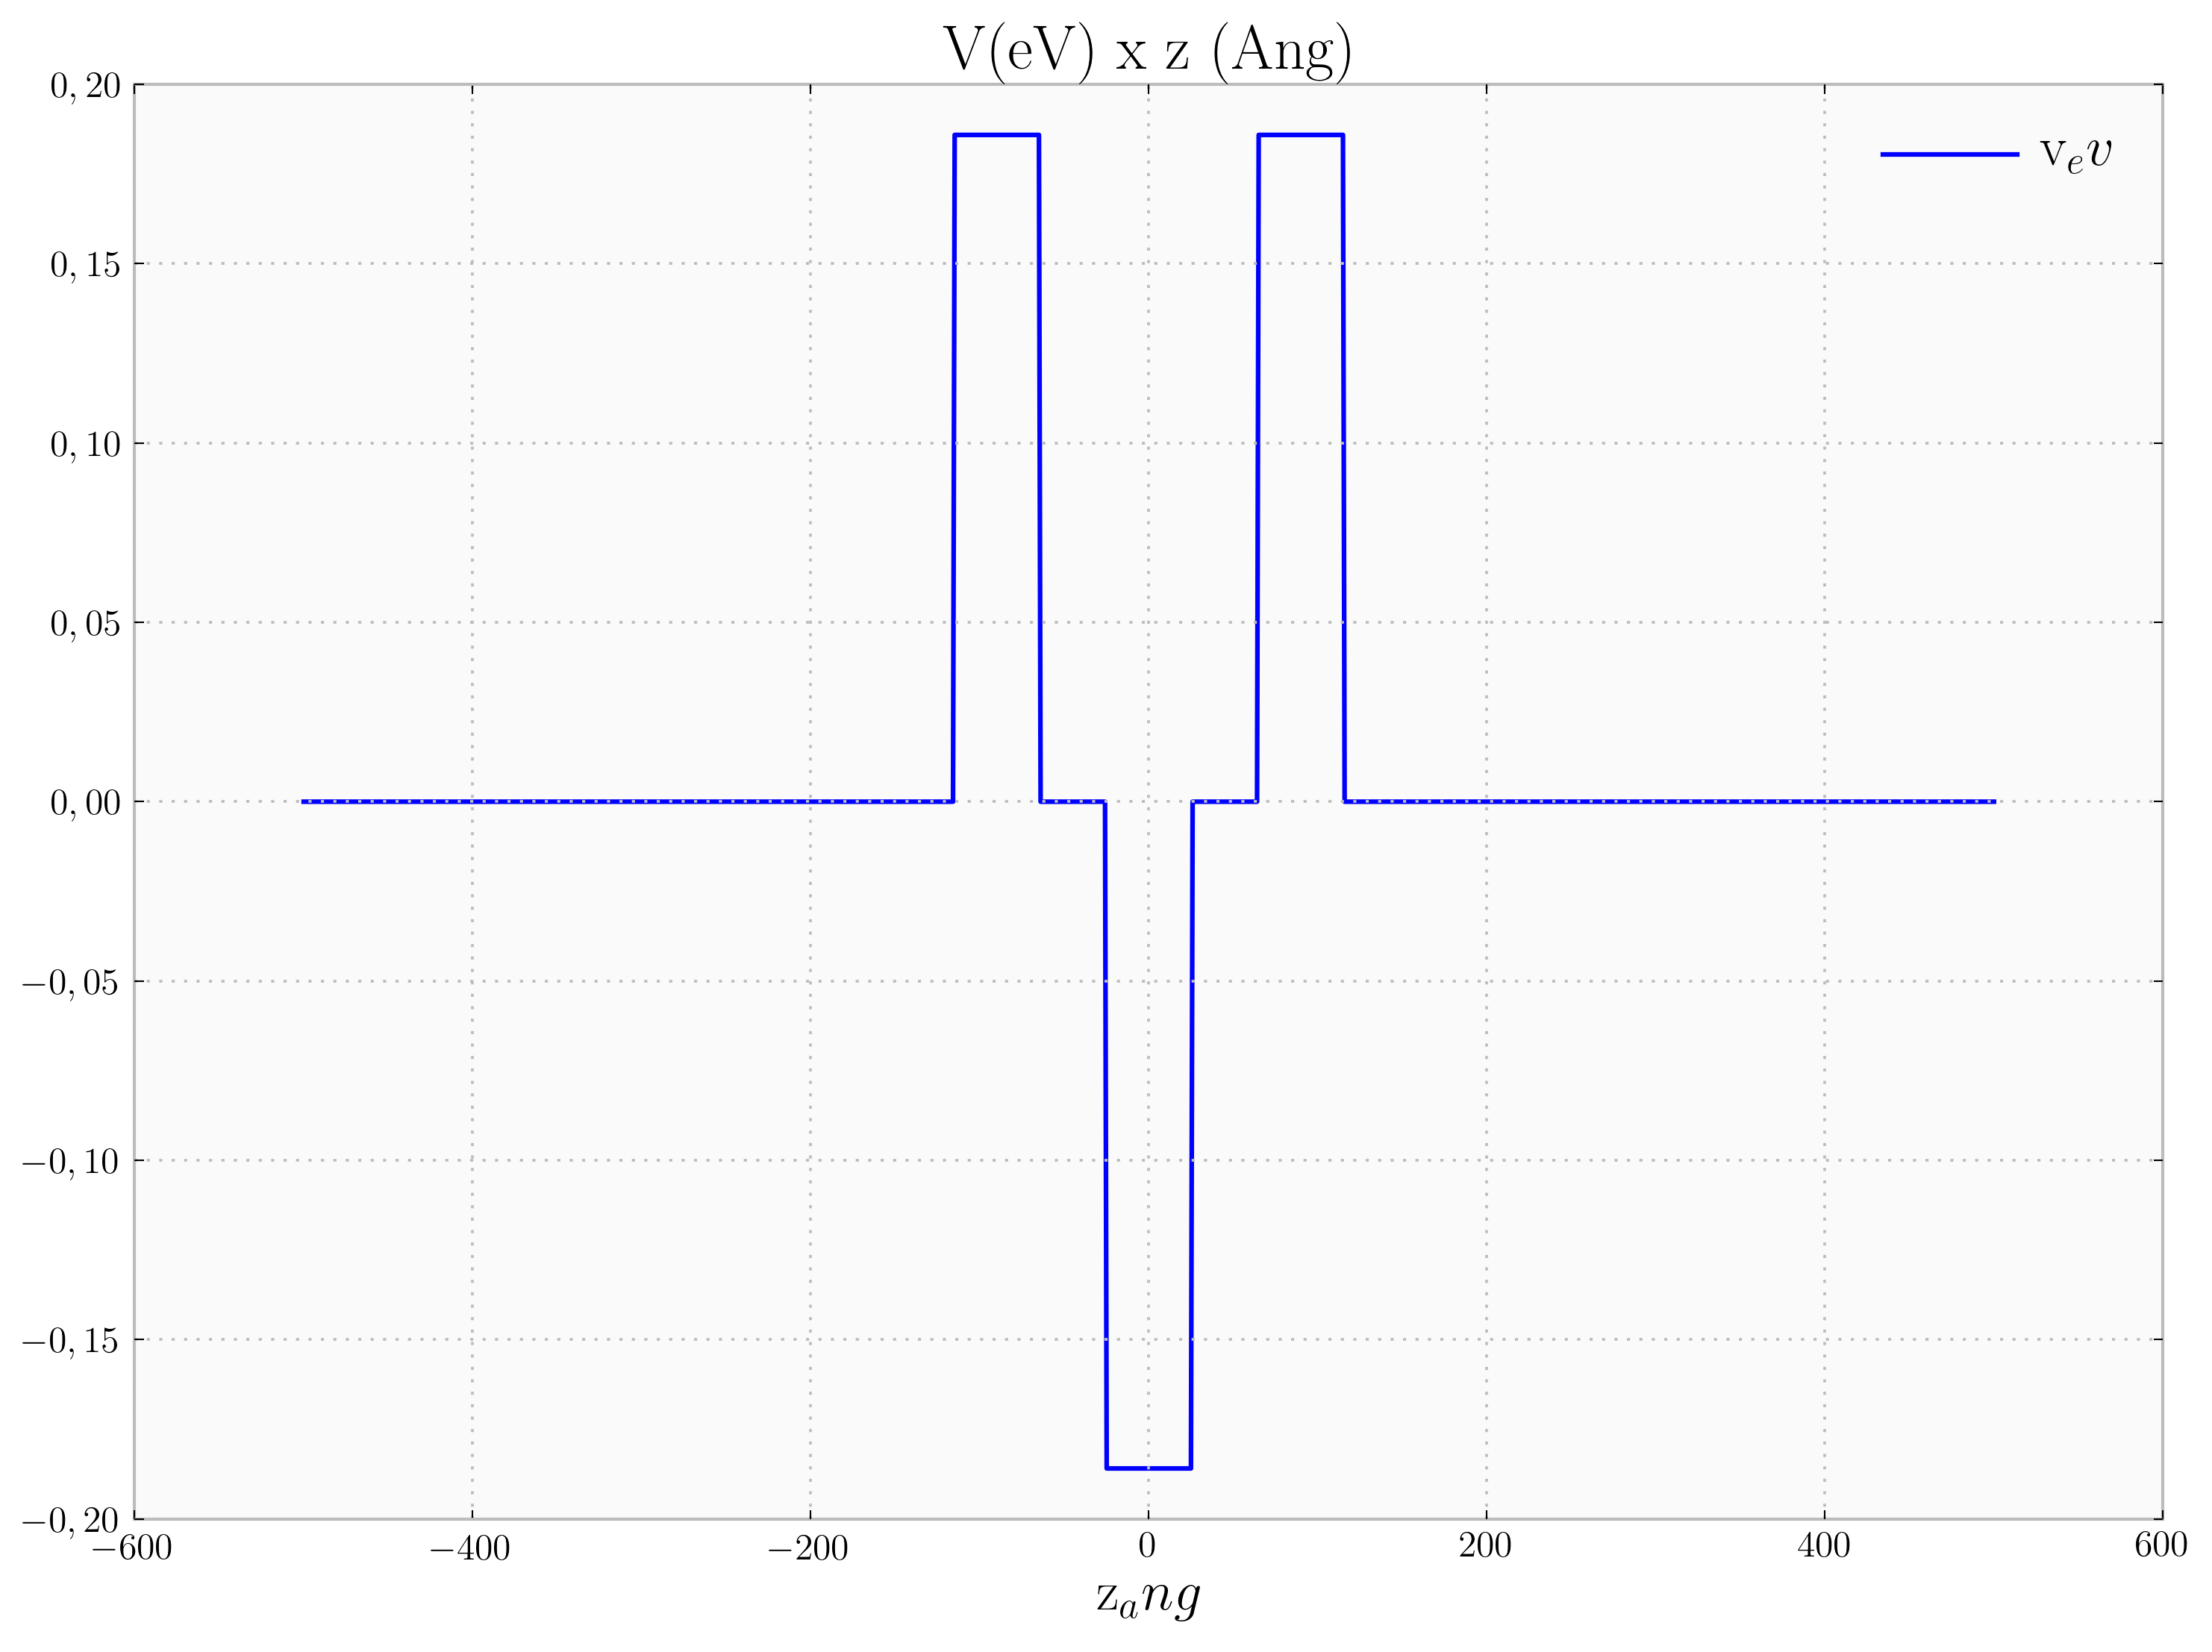

In [6]:
def algaas_gap(x):
    """Retorna o gap do material ja calculado em funcao da fracao de Aluminio
    utilizamos os valores exatos utilizados pelos referidos autores

    Params
    ------
    x : float
        a fracao de aluminio, entre 0 e 1

    Returns
    -------

    O gap em eV
    """
    if x == 0.2:
        return 0.0
    elif x == 0.4:
        return 0.185897
    return -0.185897


def algaas_meff(x):
    """Retorna a massa efetiva do AlGaAs em funcao da fracao de Aluminio
    assim como os referidos autores, utilizamos a massa efetiva do 
    eletron no GaAs ao longo de todo o material

    Params
    ------
    x : float
        a fracao de aluminio, entre 0 e 1

    Returns
    -------

    A massa efetiva do eletron no AlGaAs
    """
    return 0.067


def x_shape(z):
    """Utilizamos a concentracao de Aluminio para determinar o perfil do
    potencial

    Params
    ------

    z : float
        posicao no eixo z em angstrom

    Returns
    -------

    A concentracao de Aluminio na posicao informada
    """
    # concentracoes e larguras do sistema
    xd = 0.2  # concentracao no espaco entre poco e barreira
    xb = 0.4  # concentracao na barreira
    xw = 0.0  # concentracao no poco
    wl = 50.0  # largura do poco em angstrom
    bl = 50.0  # largura da barreira em angstrom
    dl = 40.0  # espacao entre poco e barreira em angstrom

    if np.abs(z) < wl/2:
        return xw
    elif np.abs(z) < wl/2+dl:
        return xd
    elif np.abs(z) < wl/2+dl+bl:
        return xb
    return xd


device['x'] = device['z_ang'].apply(x_shape)
device['v_ev'] = device['x'].apply(algaas_gap)
device['meff'] = device['x'].apply(algaas_meff)

pb = list(device['v_ev']).index(0.185897)  # pontos antes do dispositivo
pa = N-1-pb  # pontos depois do dispositivo

dc = device.plot(x='z_ang', y='v_ev', grid=True, title='V(eV) x z (Ang)')

## Aplicando o campo estático

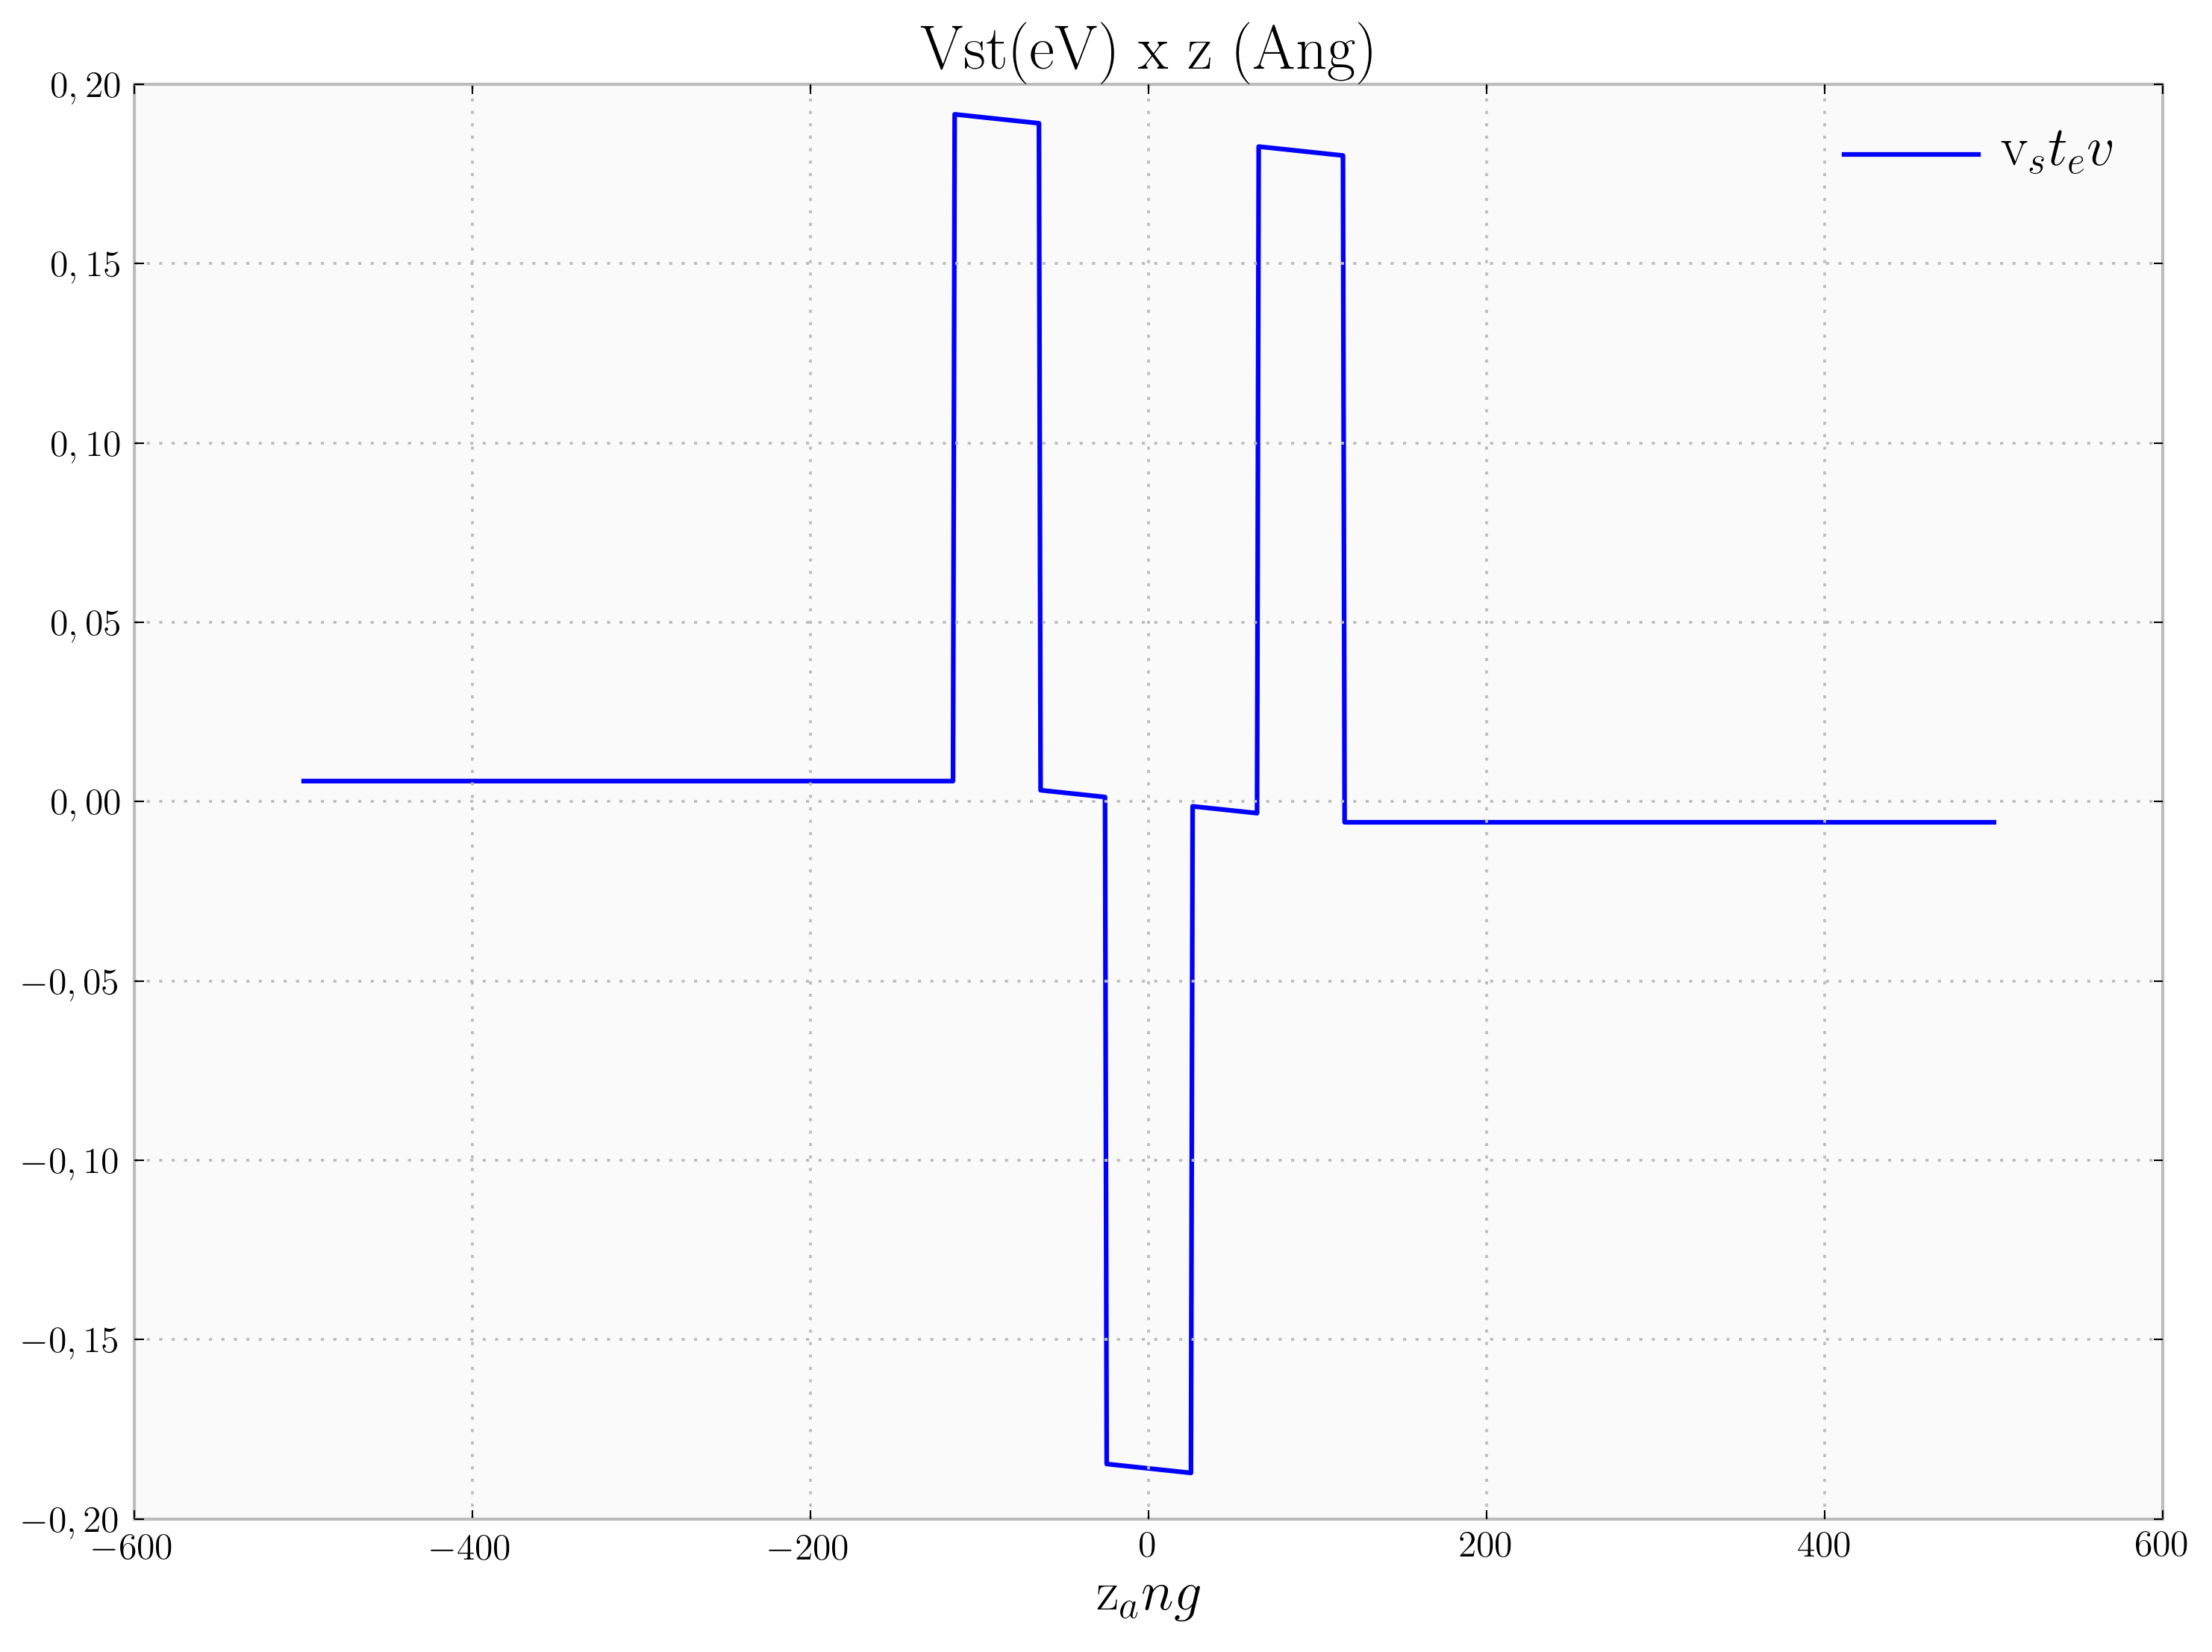

In [7]:
bias = 5.0  # KV/cm LIGAR NO CASO DE FOTOCORRENTE
bias_v_cm = bias * 1e3
bias_v_m = 1e2 * bias_v_cm
bias_j_m = bias_v_m * q


def derivada_muda_pct(x, y, n=10, pct=0.05):
    """encontra o ponto x onde a derivada de y(x) muda mais do que uma 
    certa porcentagem pela primeira vez, da esquerda para a direita

    Params
    ------
    x : array_like
        um array com os valores em x
    y : array_like
        um array com os valores em y
    n : int
        numero do pontos para ignorar nas bordas
    pct : float
        a porcentagem da derivada que deve mudar

    Returns
    -------

    O indice do ponto x onde dy/dx muda mais do que pct
    """
    der_y = np.array(y[2:]-y[:-2])/np.array(x[2:]-x[:-2])
    for i in range(n, len(der_y)):
        last_n = np.average(der_y[i-n:i-1])
        if last_n == 0 and der_y[i] != 0 \
                or last_n != 0 and np.abs(der_y[i]/last_n-1) > pct:
            return i
    return int(len(y)/3)


def __constroi_bias(z):
    """constroi o potencial estatico usado como bias/vies, nao usar fora desta
    celula

    Params
    ------

    z : float
        uma posicao no grid em angstrom

    Returns
    -------

    O bias na posicao indicada
    """
    border_left = device['z_ang'].values[pb]
    border_right = device['z_ang'].values[pa]

    def f_st_ev(z): return -(z*1e-10)*(bias_j_m)/ev

    if z <= border_left:
        return f_st_ev(border_left)
    elif z >= border_right:
        return f_st_ev(border_right)
    return f_st_ev(z)


device['bias_ev'] = device['z_ang'].apply(__constroi_bias)
device['v_st_ev'] = device['v_ev']+device['bias_ev']

dc = device.plot(x='z_ang', y='v_st_ev', grid=True, title='Vst(eV) x z (Ang)')

## Modificando alguns vetores para Unidades Atômicas

In [8]:
device['z_au'] = device['z_ang'].apply(lambda z: z / au2ang)
device['v_au'] = device['v_st_ev'].apply(lambda z: z / au2ev)
dt_au = dt / au_t

## Calculando Autovalores e Autovetores

Vamos utilizar o método da interação inversa para gerar os autovalores e autovetores. Quando o potencial estático é aplicado, dentro das condições do sistema, encontramos somente o estado fundamental.

In [9]:
def idf(v, i):
    """Indice flexivel. Por exemplo, i pode ser 1.5 e o resultado sera entao
    (v[2]+v[1])/2

    Params
    ------

    v : array_like
        um vetor
    i : float
        um indice flexivel

    Returns
    -------

    Uma interpolacao simples de v para o indice flexivel i
    """
    i_up = int(np.ceil(i))
    i_down = int(np.floor(i))
    if i_down < 0.0:
        return v[0]
    elif i_up >= len(v) - 1:
        return v[-1]
    return (v[i_up]+v[i_down])/2.0


def eigenvalue(z, V, psi, m):
    """Calcula um autovalor como E=<Psi|H|Psi>/<Psi|Psi>
    onde H = T + V, T eh o operador de energia cinetica em uma dimensao

    Params
    ------

    z : array_like
        o eixo z
    V : array_like
        o potencial
    psi : array_like
        a funcao de onda psi(z)
    m : array_like
        a massa efetiva m*(z)

    Returns
    -------

    O autovalor E=<Psi|H|Psi>/<Psi|Psi>
    """
    dz = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2 = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)

    for i in range(N):
        h_psi[i] = ((0.5/dz2[i])*(1.0/idf(m, i+0.5) +
                                  1.0/idf(m, i-0.5))+V[i])*psi[i]
        if i > 0:
            h_psi[i] += -(0.5/dz2[i])*(psi[i-1]/idf(m, i-0.5))
        if i < N-1:
            h_psi[i] += -(0.5/dz2[i])*(psi[i+1]/idf(m, i+0.5))

    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real


def chutes_iniciais(n=2, size=1024, mu=None):
    """Retorna os n primeiros polinomios de legendre modulados por uma
    gaussiana. 

    Params
    ------

    n : int
        o numero de vetores
    size : int
        o tamanho dos vetores
    mu : float
        centro da gaussiana, entre 0 e 1

    Returns
    -------

    Um array com n arrays contendo os polinomios modulados
    """
    sg = np.linspace(-1, 1, size)  # short grid
    g = gaussian(size, std=int(size/100))  # gaussian
    if mu:
        sigma = np.ptp(sg)/100
        g = (1.0/np.sqrt(2*np.pi*sigma**2))*np.exp(-(sg-mu)**2 / (2*sigma**2))
    vls = [g*legendre(i)(sg) for i in range(n)]
    return np.array(vls, dtype=np.complex_)


def calcula_autovalores_autovetores(dev):
    precision = 1e-9  # precisao a ser usada para calculos numericos
    nmax = 20  # numero maximo de intervalos

    #
    forecast = np.linspace(dev['v_au'].min(), dev['v_au'].max(), nmax)
    dz = dev['z_au'][1]-dev['z_au'][0]
    dz2 = dz**2

    # chutes iniciais
    eigenstates = chutes_iniciais(nmax, size=N)
    eigenvalues = np.zeros(nmax)

    counters = np.zeros(nmax)
    timers = np.zeros(nmax)
    precisions = np.zeros(nmax)
    vectors_sqeuclidean = np.zeros(nmax)

    V = dev['v_au'].values
    m = dev['meff'].values
    z = dev['z_au'].values

    for s in range(nmax):
        last_ev = 1.0  # autovalor inicial fake
        last_es = np.zeros(N, dtype=np.complex_)  # autovetor inicial
        shift = forecast[s]

        # Desloca o potencial do Hamiltoniano por shift
        sub_diag = np.zeros(N-1, dtype=np.complex_)
        main_diag = np.zeros(N, dtype=np.complex_)

        # constroi as diagnais da matriz, a principal e as duas semi
        # principais
        for i in range(N):
            try:
                main_diag[i] = (0.5/dz2)*(1.0/idf(m, i+0.5) +
                                          1.0/idf(m, i-0.5))+(V[i]-shift)
            except:
                main_diag[i] = 0.0

            if i < N-1:
                sub_diag[i] = -(0.5/dz2)*(1.0/idf(m, i+0.5))

        diagonals = [main_diag, sub_diag, sub_diag]
        A = diags(diagonals, [0, -1, 1]).toarray()

        invA = inv(A)

        V_shifted = V-shift

        while True:
            start_time = time.time()
            eigenstates[s] = invA.dot(eigenstates[s])
            counters[s] += 1

            # normaliza
            A = np.sqrt(simps(eigenstates[s]*eigenstates[s].conj(), z))
            eigenstates[s] /= A
            timers[s] += time.time() - start_time

            eigenvalues[s] = eigenvalue(z, V_shifted, eigenstates[s], m) + shift

            # confere precisao
            precisions[s] = np.abs(1-eigenvalues[s]/last_ev)
            last_ev = eigenvalues[s]

            if precisions[s] < precision:
                XA = [np.abs(eigenstates[s])**2]
                XB = [np.abs(last_es)**2]
                vectors_sqeuclidean[s] = cdist(XA, XB, 'sqeuclidean')[0][0]
                break

            last_es = np.copy(eigenstates[s])

    sort_index = eigenvalues.argsort()
    eigenvalues = eigenvalues[sort_index]
    eigenstates = eigenstates[sort_index]

    iz_left = derivada_muda_pct(z, V)
    iz_right = len(V)-derivada_muda_pct(z, V[::-1])
    golden_ones = [0]

    for i in range(eigenvalues.size):
        # remove estados repetidos e nao confinados
        if i == 0 or np.abs(eigenvalues[i]/eigenvalues[i-1]-1) < 0.1 \
                or eigenvalues[i] > np.max(V):
            continue

        # remove os estados nao confinados lateralmente
        state = eigenstates[i].copy()
        state_l = state[:iz_left]
        state_m = state[iz_left:iz_right]
        state_r = state[iz_right:]
        int_left = simps(state_l*state_l.conj(), z[:iz_left]).real
        int_mid = simps(state_m*state_m.conj(), z[iz_left:iz_right]).real
        int_right = simps(state_r*state_r.conj(), z[iz_right:]).real

        if int_left+int_right > int_mid:
            continue

        golden_ones.append(i)

    eigenvalues = eigenvalues[golden_ones] * au2ev
    eigenstates = eigenstates[golden_ones]
    counters = counters[golden_ones]
    timers = timers[golden_ones]
    precisions = precisions[golden_ones]
    squared_euclidean_dist = vectors_sqeuclidean[golden_ones]

    for i, state in enumerate(eigenstates):
        AN = np.sqrt(simps(state.conj() * state, dev['z_ang']))
        dev['state_%d' % i] = state / AN
    return dev, eigenvalues, eigenstates

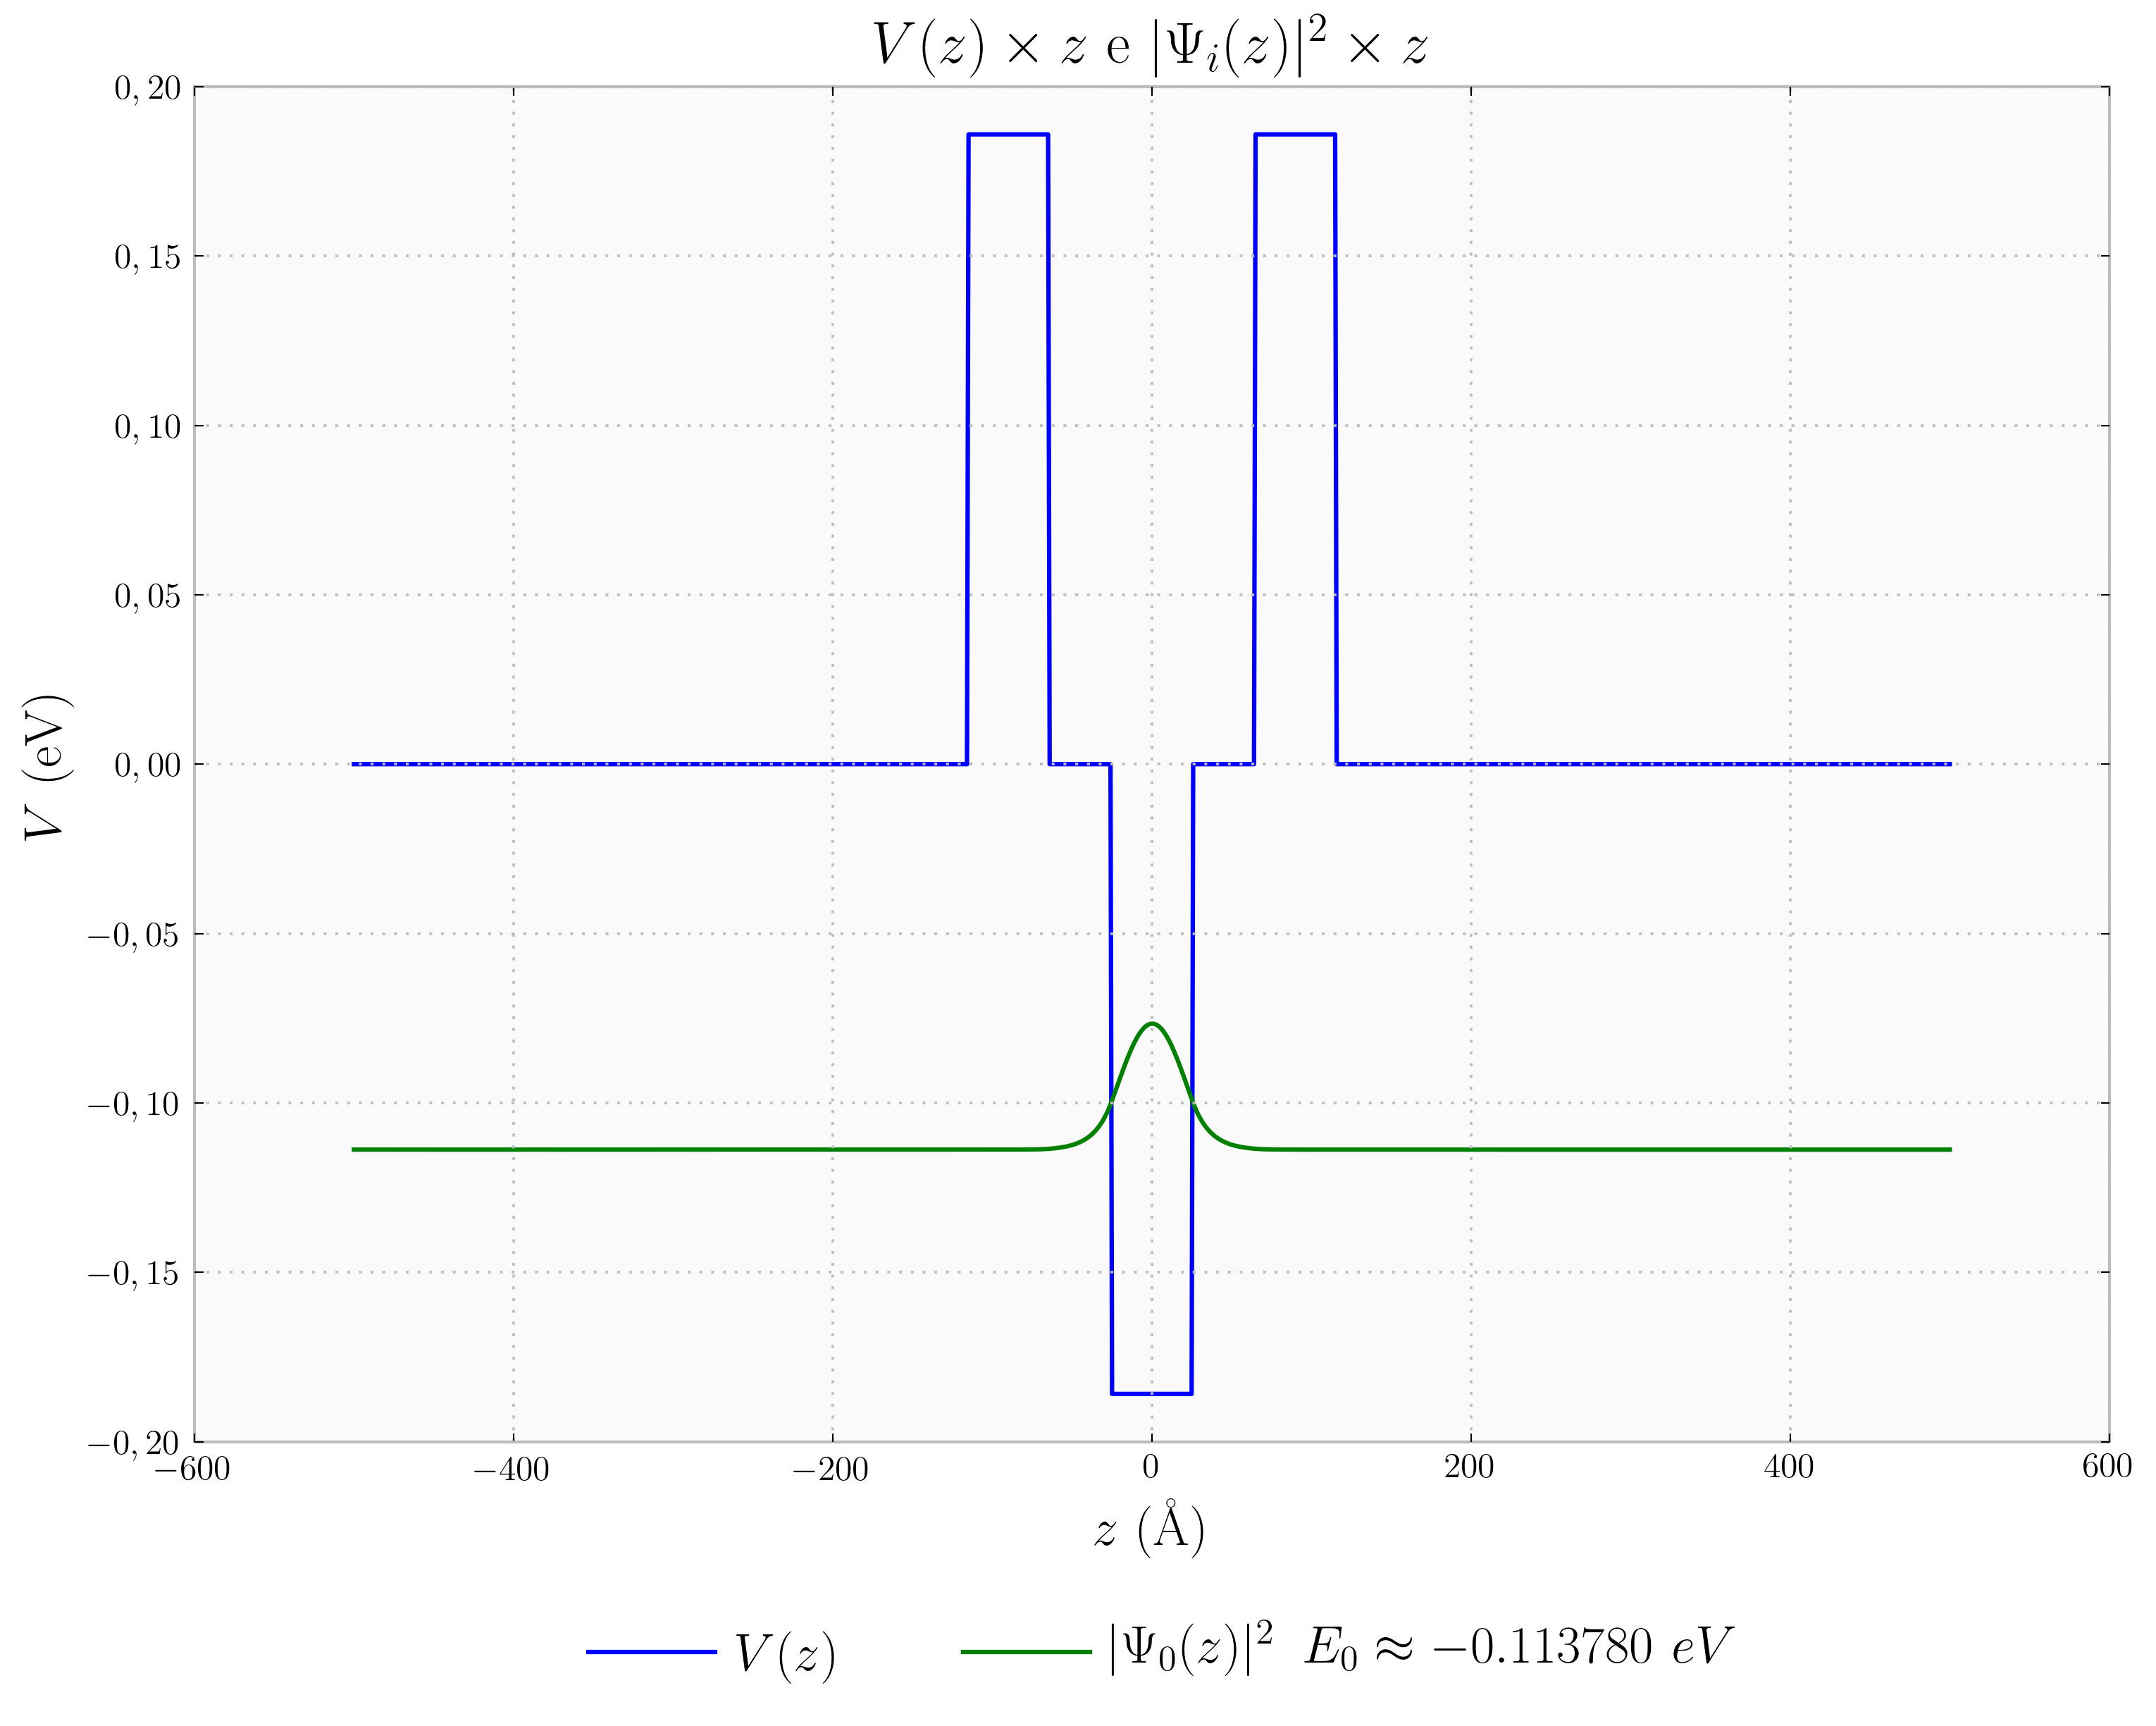

In [9]:
device, eigenvalues, eigenstates = calcula_autovalores_autovetores(device)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'$V$ (eV)')
ax.plot(device.z_ang, device.v_ev, label=r'$V(z)$')

vpp = np.ptp(device.v_ev)

for i, state in enumerate(eigenstates):
    _eivenvalue = eigenvalues[i]
    
    psi = np.abs(state)**2
    psi *= vpp / np.ptp(psi) / 10
    psi = (psi).real + _eivenvalue
    
    ax.plot(device.z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.set_title(r"$V(z) \times z$ e $|\Psi_i(z)|^2 \times z$")
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
#plt.show()
plt.savefig('figuras/double_barrier_quantum_well_degani.png', bbox_inches='tight')

## Potencial absorvedor

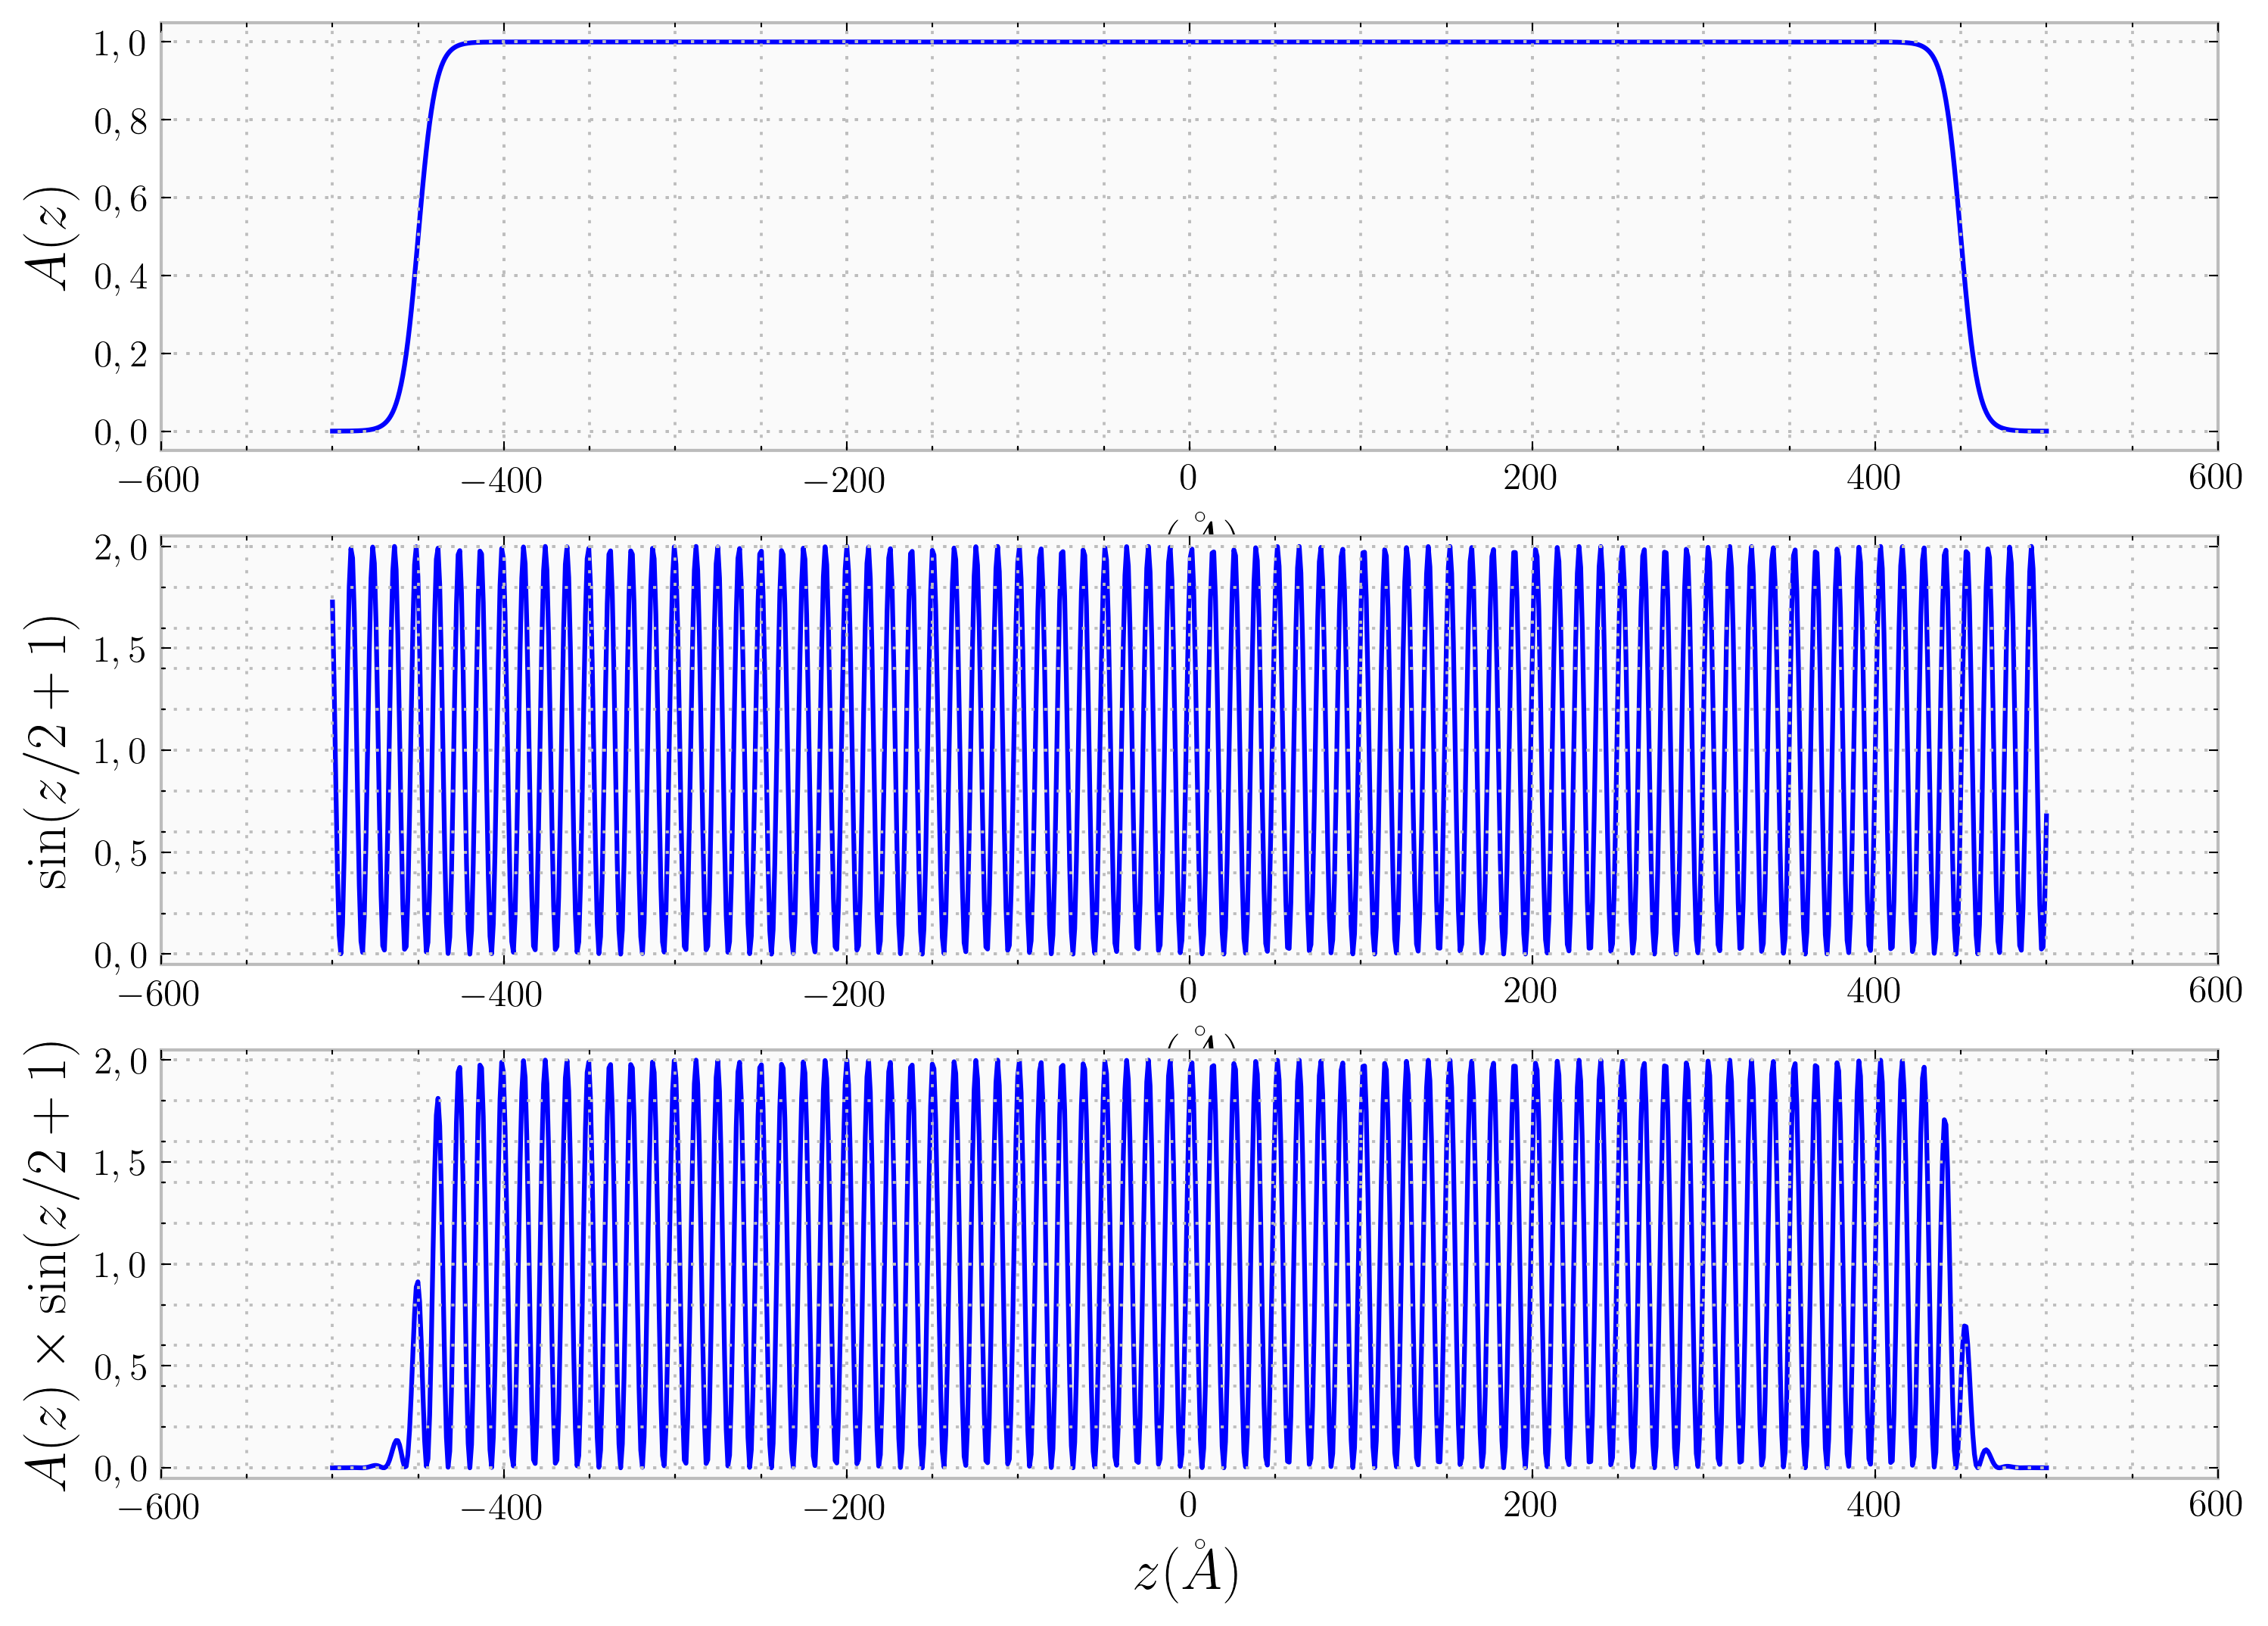

In [46]:
L = 1000.0
N = 1024
z = np.linspace(-L/2,L/2,N)
killer = np.array([min(l,r) for l,r in zip(expit((450-z)/5), expit((z+450)/5))])
to_kill = (1+np.sin(z/2+1))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.set_xlabel(r'$z (\AA)$')
ax1.set_ylabel(r'$A(z)$')
ax1.plot(z, killer)
ax1.xaxis.set_minor_locator(MultipleLocator(50))
ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1.set_ylim([-0.05, 1.05])
ax1.grid(which = 'minor')

ax2.set_xlabel(r'$z (\AA)$')
ax2.set_ylabel(r'$\sin(z/2+1)$')
ax2.plot(z, to_kill)
ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(0.2))
ax2.set_ylim([-0.05, 2.05])
ax2.grid(which = 'minor')

ax3.set_xlabel(r'$z (\AA)$')
ax3.set_ylabel(r'$A(z) \times \sin(z/2+1)$')
ax3.plot(z, killer*to_kill)
ax3.xaxis.set_minor_locator(MultipleLocator(50))
ax3.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.set_ylim([-0.05, 2.05])
ax3.grid(which = 'minor')


#plt.show()
plt.savefig('figuras/absorvedor_exemplo.png', bbox_inches='tight')

# Fotocorrente

In [10]:
def fotocorrente(energy, fosc=5.0, T=1e-12):
    """Calcula a fotocorrente para uma dada energia em eV (do campo eletrico)

    Params
    ------

    energy : float
        energia dos fotons incidentes em eV
    fosc : float
        intensidade do potencial oscilante em KV/cm
    T : float
        tempo total de evolucao em segundos

    Returns
    -------

    A fotocorrente 
    """

    fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
    T_au = T / au_t
    iters = int(T_au / dt_au)
    t_grid_au = np.linspace(0.0, T_au, iters)

    psi = np.array(device.state_0, dtype=np.complex_)
    psi /= np.sqrt(simps(psi*psi.conj(), device.z_au))

    meff = device['meff'].values
    z_au = device['z_au'].values
    dz_au = z_au[1]-z_au[0]
    k_au = fftfreq(N, d=dz_au)
    j_t = np.zeros(iters)

    def j_p(p):
        """J=1/(2 i m*) (psi* d(psi)/dz - psi d(psi*)/dz) """
        dzp = z_au[p+1]-z_au[p-1]
        pcdp = psi[p].conj() * (psi[p+1]-psi[p-1]) / dzp
        pdpc = psi[p] * (psi[p+1].conj()-psi[p-1].conj()) / dzp
        return ((-0.5j/(meff[p])) * (pcdp-pdpc)).real

    absorbing = device['z_ang'].apply(
        lambda z: min(expit((450-z)/5), expit((z+450)/5)))

    z0_ang = device['z_ang'].values[0]
    fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
    fosc_ev = fosc_j / ev
    fosc_au = fosc_ev / au2ev

    omega_au = (energy / au2ev) / hbar_au

    v_au_ti = device['v_au'].values
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
    #exp_v2h = np.exp(- 0.5j * v_au_ti * dt_au)
    exp_v2h = np.exp(- 1.0j * v_au_ti * dt_au)

    #f_espec = - 0.5j * fosc_au * dt_au
    f_espec = - 1.0j * fosc_au * dt_au

#     timer_alloc = 0.0
#     timer_evolv = 0.0
#     timer_photo = 0.0

    for i, t_au in enumerate(t_grid_au):
        
        #start_time = time.time()
        exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
        #timer_alloc += time.time() - start_time

        #start_time = time.time()
        #psi = exp_v2 * ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        psi = ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        #timer_evolv += time.time() - start_time

        #start_time = time.time()
        j_t[i] = j_p(pb-100)-j_p(pa+100)
        #timer_photo += time.time() - start_time

#         if i % 10000 == 0 and i > 0:
#             evolved = psi.copy()
#             evolved /= np.sqrt(simps(np.conjugate(psi)*psi, device['z_ang'].values))
#             device['state_0_evolved'] = evolved
#             device['state_0_evolved_norm'] = (np.abs(evolved)**2).real
#             device.plot(x='z_ang', y=['v_ev', 'state_0_evolved_norm'])
#             plt.plot()

#     print("Alocando: %.8f s" % (timer_alloc/t_grid_au.size))
#     print("Evoluindo: %.8f s" % (timer_evolv/t_grid_au.size))
#     print("Corrente: %.8f s" % (timer_photo/t_grid_au.size))

    return q * (simps(j_t, t_grid_au) / T_au) / T

In [ ]:
energies = np.linspace(0.1, 0.4, 300) # energy from 100 meV to 400 meV
photocurrent = []
def get_pc(energy):
    pc = fotocorrente(energy=energy)
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print("[%s] > Energy: %.6f eV, PC: %.6e " % (now, energy, pc))
    return pc
pool = Pool(processes=4)
photocurrent = pool.map(get_pc, energies)
np.savez("saidas/photocurrent", energies, photocurrent)

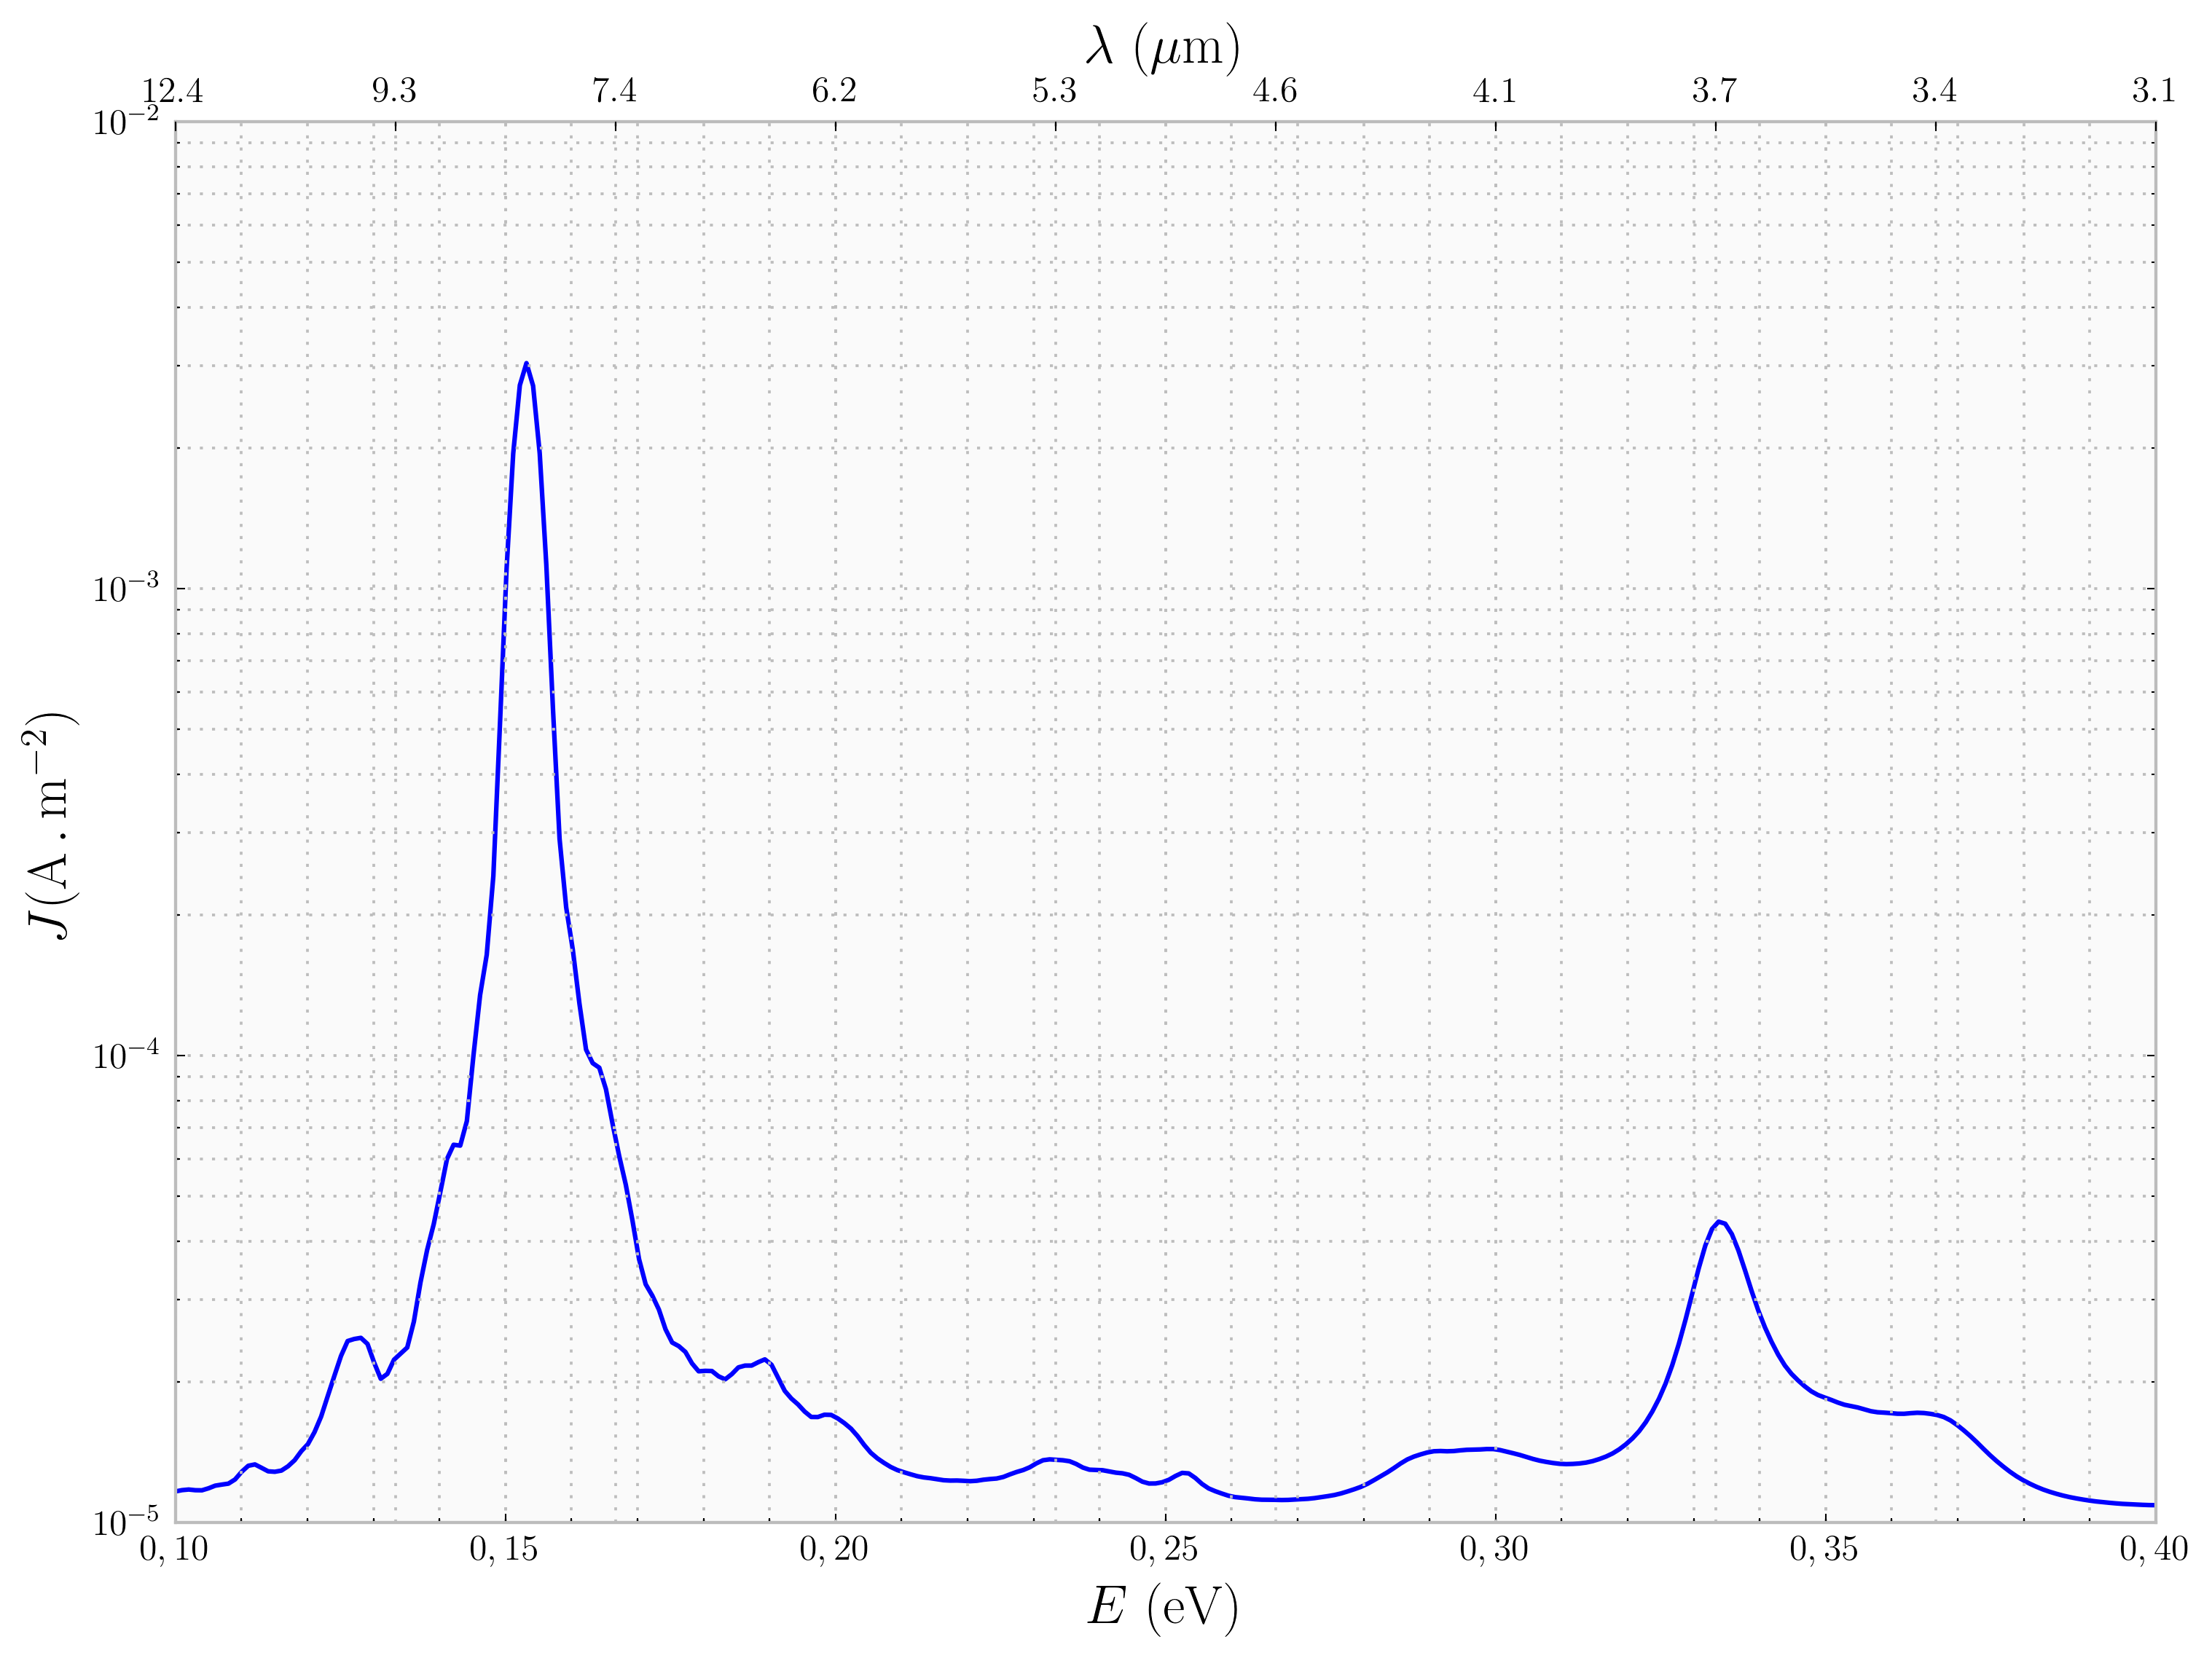

In [77]:
loads = np.load("saidas/photocurrent.npz")
energies, photocurrent = loads['arr_0'], loads['arr_1']

fig, ax = plt.subplots()

ax.set_xlabel(r'$E$ (eV)')
ax.set_ylabel(r'$J (\mathrm{A}\, .\, \mathrm{m}^{-2})$')
ax.semilogy(energies, -np.array(photocurrent)*1e10)

ax2 = ax.twiny()
tiny_energies = np.linspace(0.1, 0.4, 10)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(tiny_energies)
ax2.set_xticklabels(["%.1f" % ((h * c / (e * ev))/1e-6) for e in tiny_energies])
ax2.set_xlabel(r"$\lambda$ ($\mu$m)")

minorLocator_x = MultipleLocator(0.01)
ax.xaxis.set_minor_locator(minorLocator_x)
ax.grid(which = 'minor')
plt.savefig('figuras/fotocorrente_degani.png', bbox_inches='tight')

## Absorção

### Definindo novamente o sistema

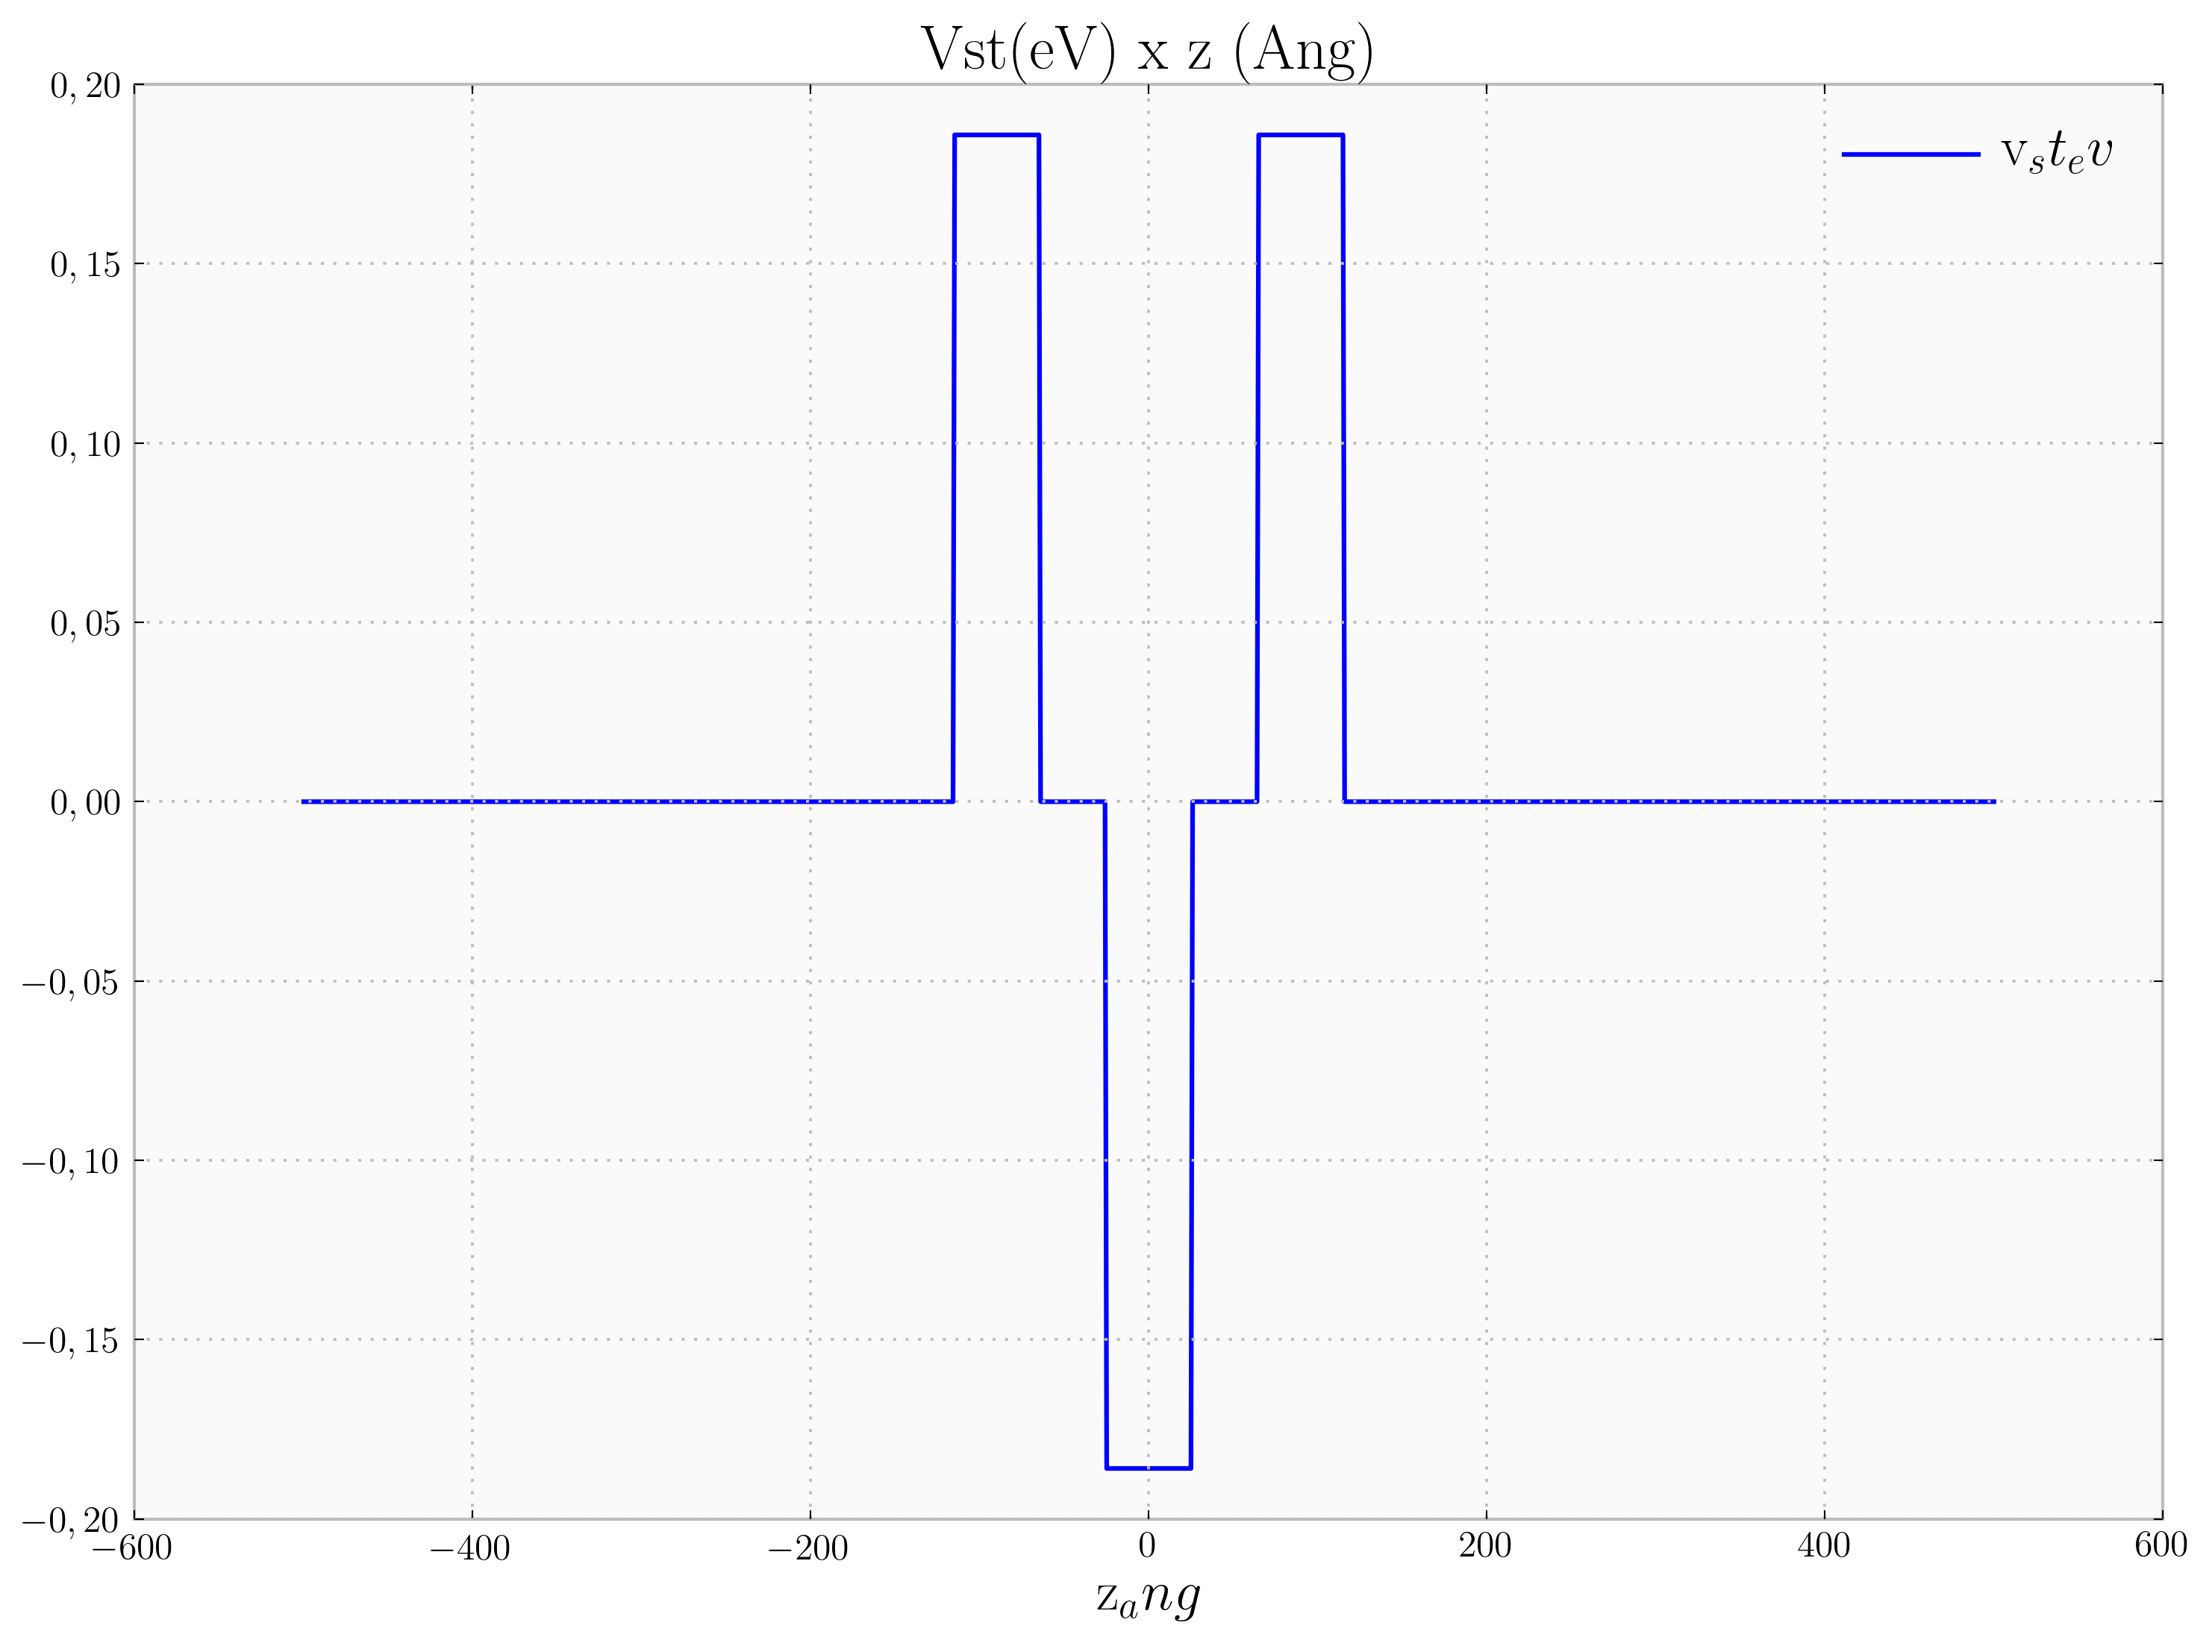

In [10]:
# dataframe de pandas com valores utilizados para calculos
device = pd.DataFrame()
N = 1024  # tamanho padrao do grid
L = 500.0  # tamanho padrao do sistema em angstrom
dt = 1e-17  # incremento de tempo padrao em segundos
device['z_ang'] = np.linspace(-L/2, L/2, N)  # malha espacial em angstrom
device['z_au'] = device['z_ang'].apply(lambda z: z / au2ang)
device['x'] = device['z_ang'].apply(x_shape)
device['v_ev'] = device['x'].apply(algaas_gap)
device['meff'] = device['x'].apply(algaas_meff)
pb = list(device['v_ev']).index(0.185897)  # pontos antes do dispositivo
pa = N-1-pb  # pontos depois do dispositivo

# não precisa de bias
bias = 0.0
bias_v_cm = bias * 1e3
bias_v_m = 1e2 * bias_v_cm
bias_j_m = bias_v_m * q

# mas precisa de campo elétrico
fosc = 5.0 # KV/cm
fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
fosc_au = fosc_j_m / au_ef
z_au = device.z_au
Hpo = z_au * fosc_au


def __constroi_bias(z):
    """constroi o potencial estatico usado como bias/vies, nao usar fora desta
    celula

    Params
    ------

    z : float
        uma posicao no grid em angstrom

    Returns
    -------

    O bias na posicao indicada
    """
    border_left = device['z_ang'].values[pb]
    border_right = device['z_ang'].values[pa]

    def f_st_ev(z): return -(z*1e-10)*(bias_j_m)/ev

    if z <= border_left:
        return f_st_ev(border_left)
    elif z >= border_right:
        return f_st_ev(border_right)
    return f_st_ev(z)


device['bias_ev'] = device['z_ang'].apply(__constroi_bias)
device['v_st_ev'] = device['v_ev']+device['bias_ev']
device['v_au'] = device['v_st_ev'].apply(lambda z: z / au2ev)
dt_au = dt / au_t
dc = device.plot(x='z_ang', y='v_st_ev', grid=True, title='Vst(eV) x z (Ang)')

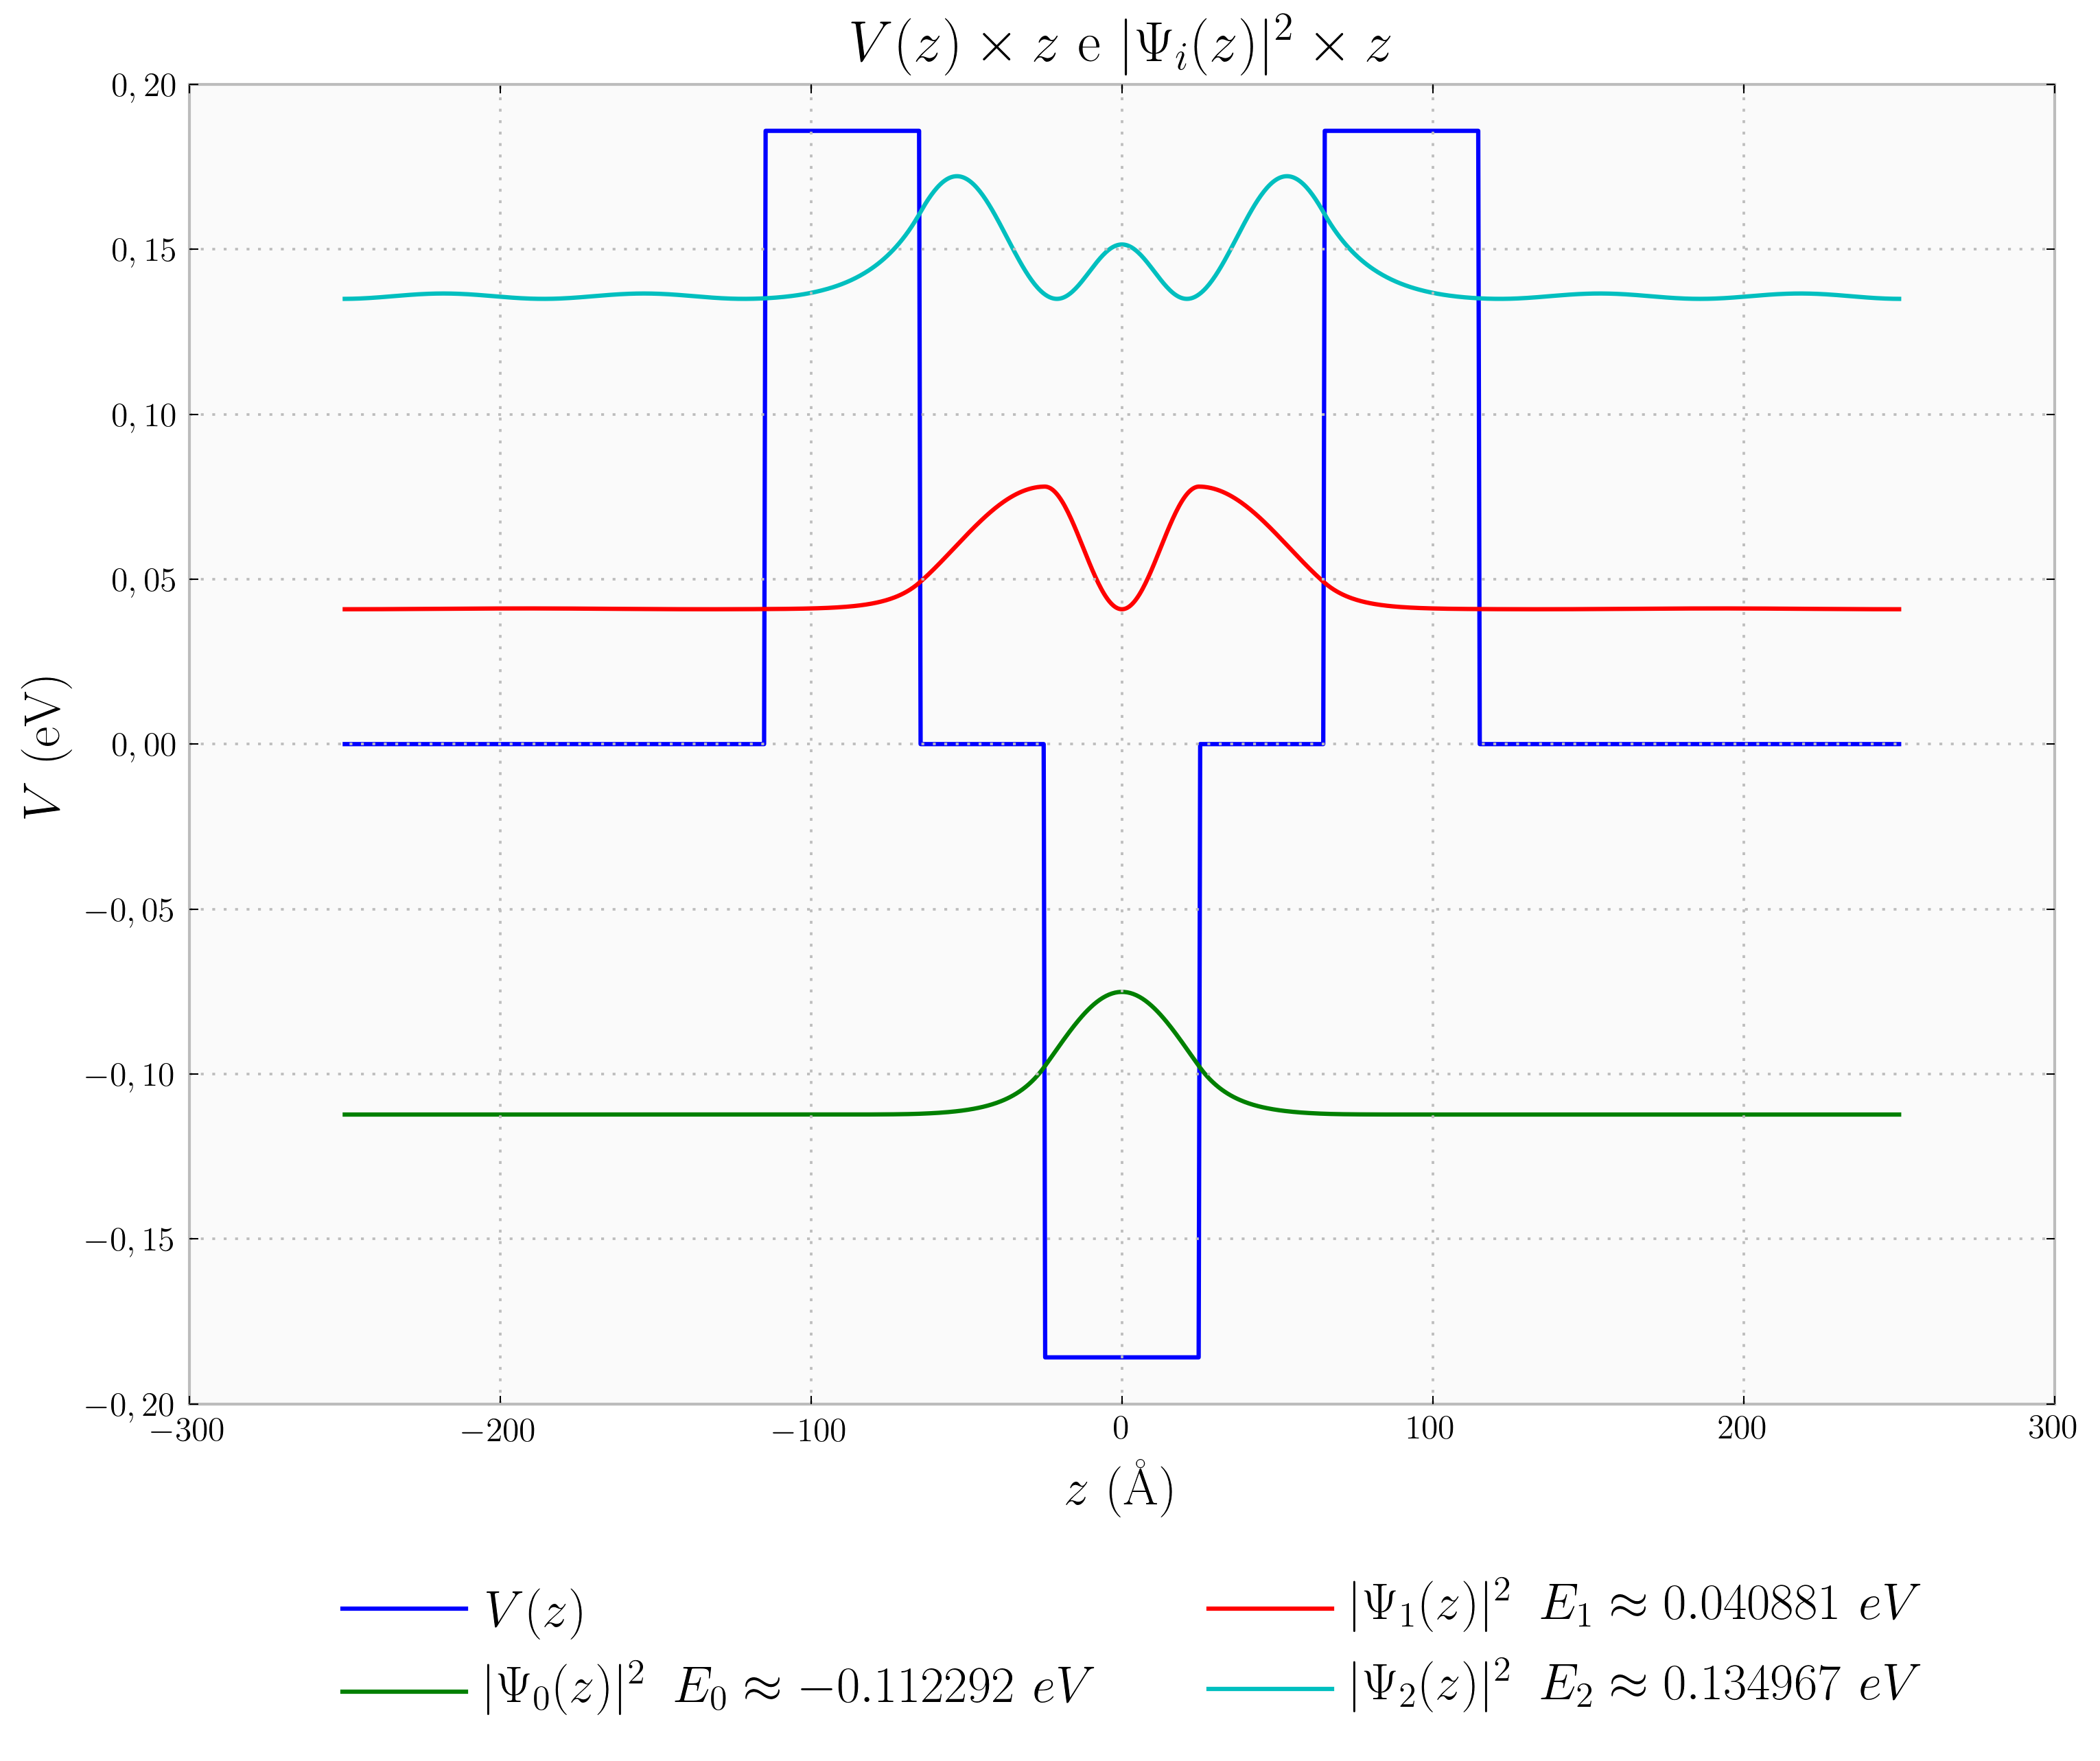

In [10]:
device, eigenvalues, eigenstates = calcula_autovalores_autovetores(device)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'$V$ (eV)')
ax.plot(device.z_ang, device.v_ev, label=r'$V(z)$')

vpp = np.ptp(device.v_ev)

for i, state in enumerate(eigenstates):
    _eivenvalue = eigenvalues[i]
    
    psi = np.abs(state)**2
    psi *= vpp / np.ptp(psi) / 10
    psi = (psi).real + _eivenvalue
    
    ax.plot(device.z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.set_title(r"$V(z) \times z$ e $|\Psi_i(z)|^2 \times z$")
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
#plt.show()
plt.savefig('figuras/double_barrier_quantum_well_degani_sem_vies.png', bbox_inches='tight')

## Absorção com regra de ouro de Fermi

In [22]:
psi0 = eigenstates[0].copy()
psi0_au = psi0 / np.sqrt(simps(psi0.conj()*psi0,z_au))
e0_au = eigenvalues[0] / au2ev

psi1 = eigenstates[1].copy()
psi1_au = psi1 / np.sqrt(simps(psi1.conj()*psi1,z_au))
e1_au = eigenvalues[1] / au2ev

psi2 = eigenstates[2].copy()
psi2_au = psi2 / np.sqrt(simps(psi2.conj()*psi2,z_au))
e2_au = eigenvalues[2] / au2ev

w10_au = (e1_au-e0_au) / hbar_au
w20_au = (e2_au-e0_au) / hbar_au

p1_Hpo_p0_au = simps(psi0_au.conj() * Hpo * psi1_au, z_au)
p1_Hpo_p0_au_2 = p1_Hpo_p0_au.conj() * p1_Hpo_p0_au

p2_Hpo_p0_au = simps(psi0_au.conj() * Hpo * psi2_au, z_au)
p2_Hpo_p0_au_2 = p2_Hpo_p0_au.conj() * p2_Hpo_p0_au

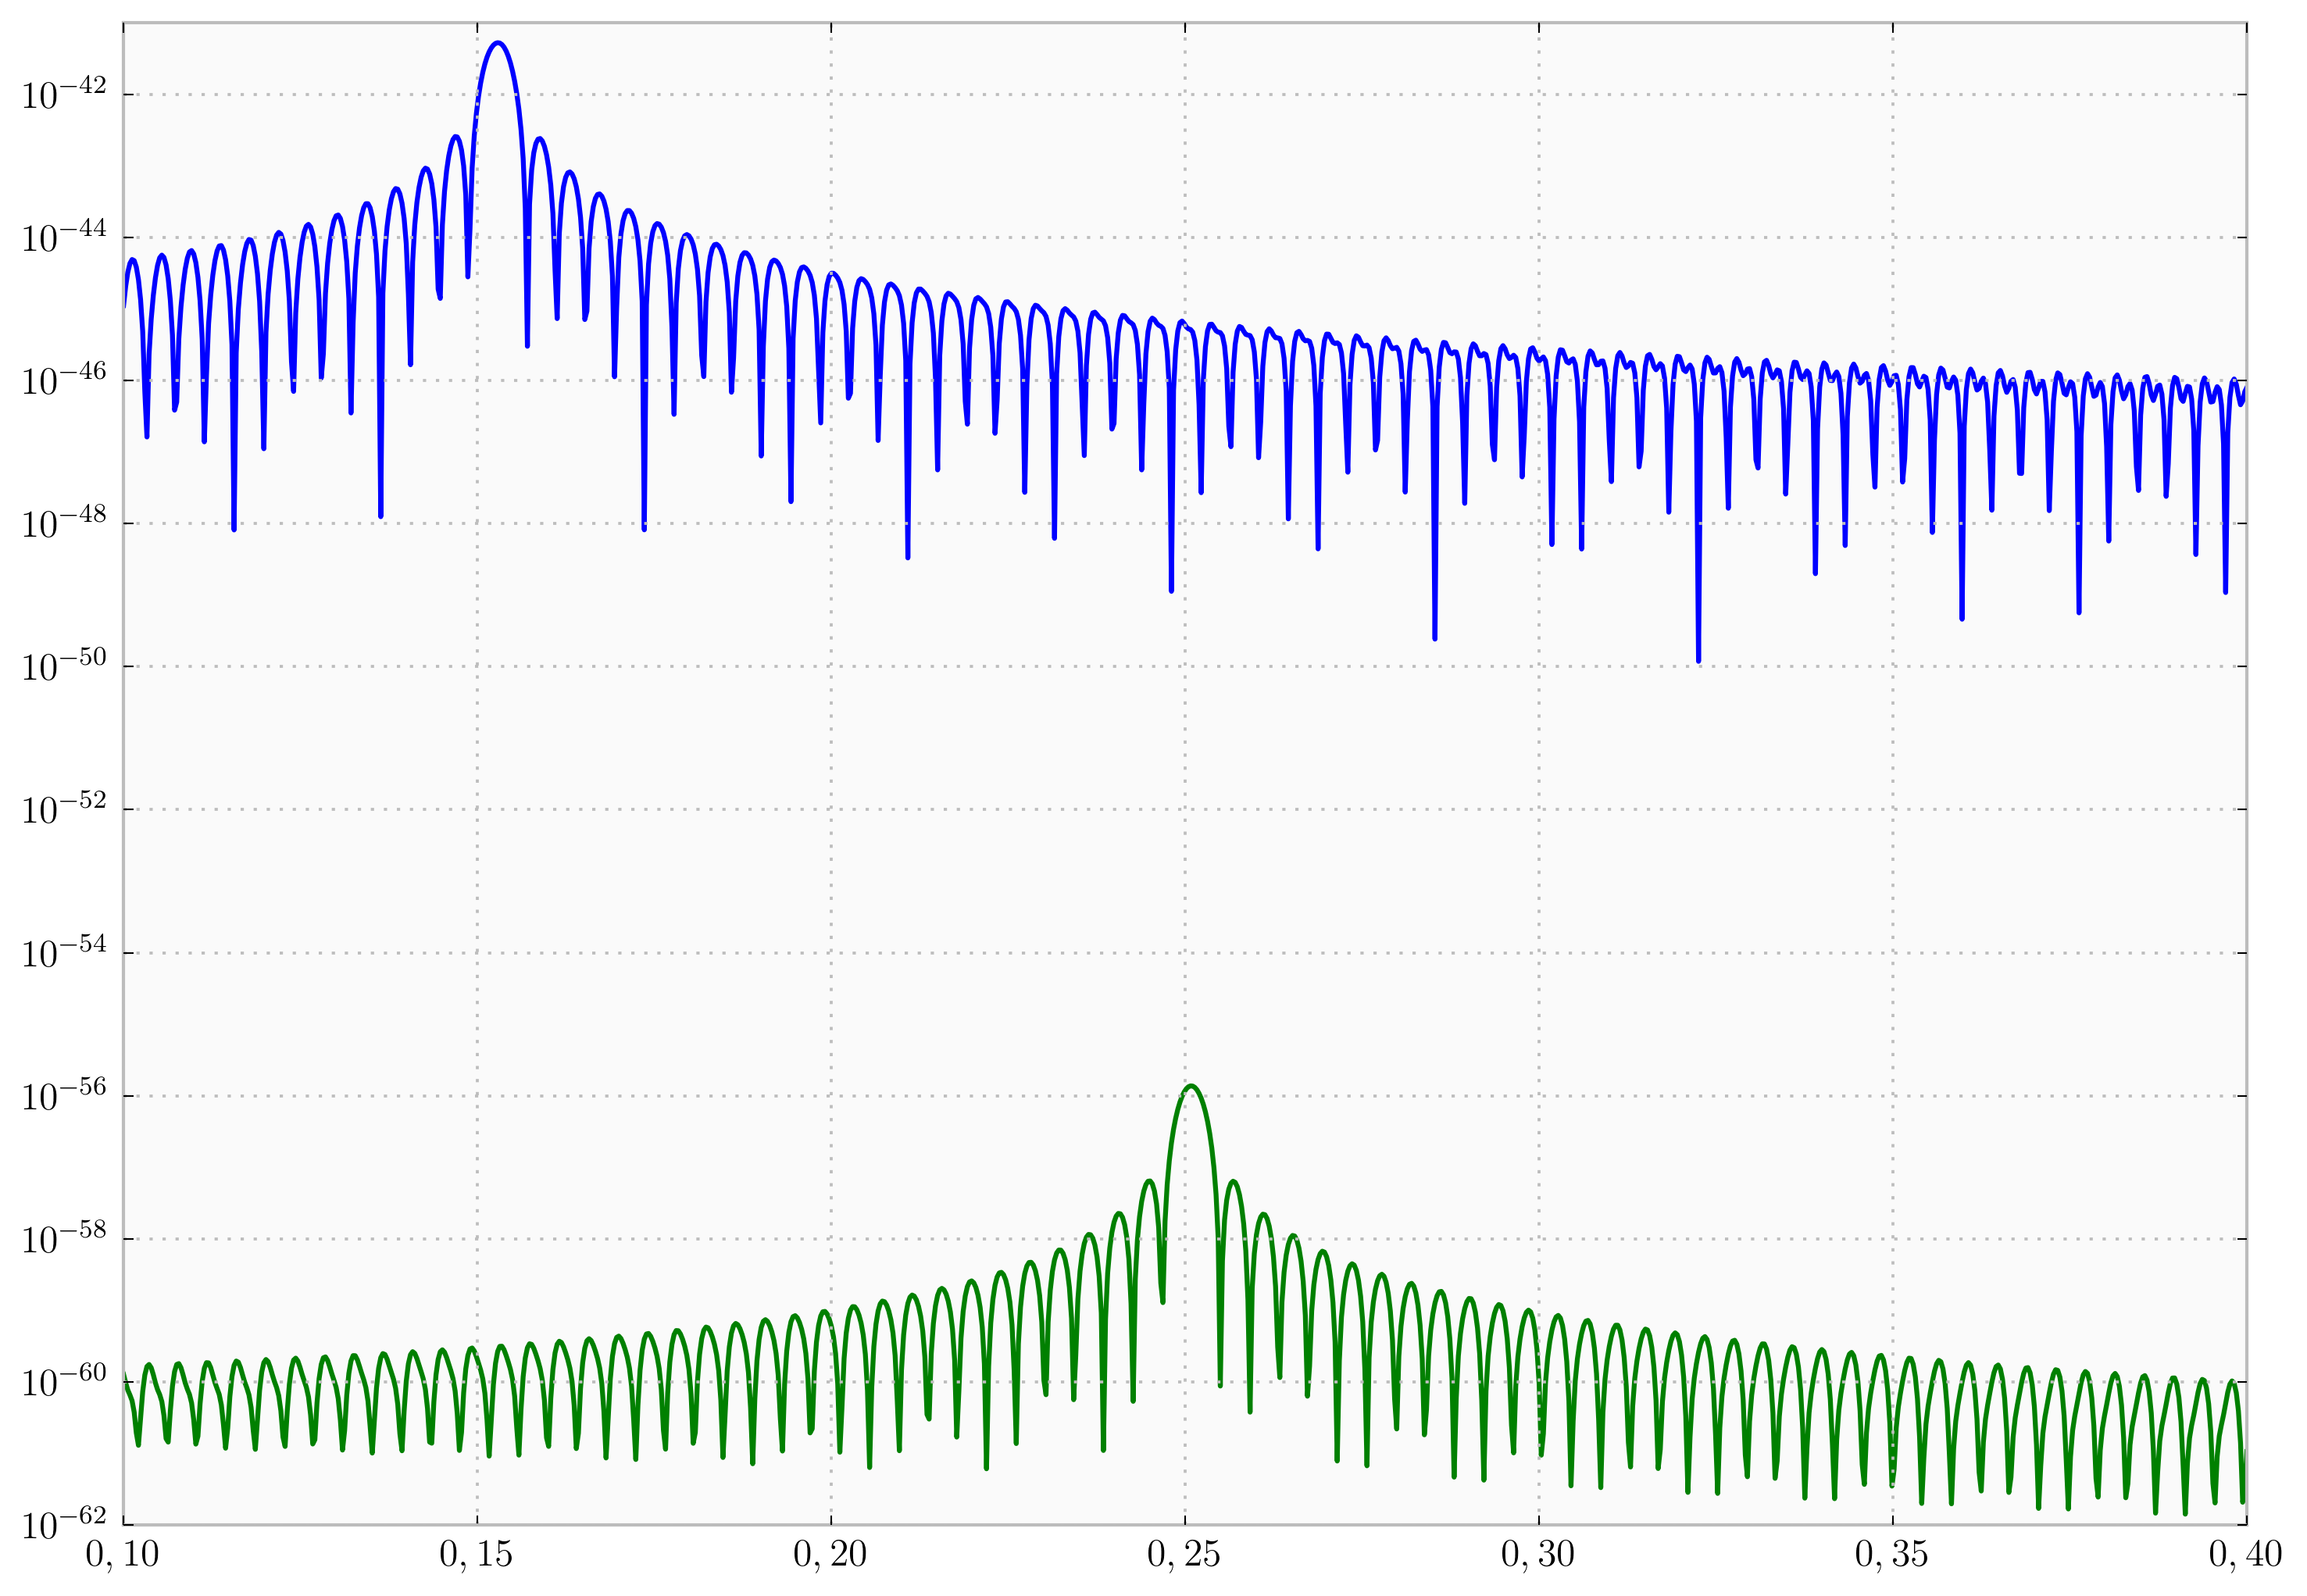

In [23]:
energies = np.linspace(0.1, 0.4, 1000) # ev
energies_au = energies / au2ev
omegas_au = energies_au / hbar_au

t0 = 1e-12
t0_au = t0 / au_t
pcte10 = t0_au**2 * p1_Hpo_p0_au_2
pcte20 = t0_au**2 * p2_Hpo_p0_au_2

def absorption10(w_au):
    a1 = (np.sin((w10_au-w_au)*t0_au/2))/((w10_au-w_au)*t0_au/2)
    a2 = (np.sin((w10_au+w_au)*t0_au/2))/((w10_au+w_au)*t0_au/2)
    a3 = 2.0*np.cos(w_au*t0_au) * a1 * a2
    return (pcte10 * (a1**2+a2**2+a3)).real

def absorption20(w_au):
    a1 = (np.sin((w20_au-w_au)*t0_au/2))/((w20_au-w_au)*t0_au/2)
    a2 = (np.sin((w20_au+w_au)*t0_au/2))/((w20_au+w_au)*t0_au/2)
    a3 = 2.0*np.cos(w_au*t0_au) * a1 * a2
    return (pcte20 * (a1**2+a2**2+a3)).real


plt.semilogy(omegas_au*au2ev, np.vectorize(absorption10)(omegas_au).real)
plt.semilogy(omegas_au*au2ev, np.vectorize(absorption20)(omegas_au).real)
plt.show()

### Absorção com evolução tempoal

In [24]:
def absorption_time_evolution(energy, fosc=5.0, T=1e-12):
    fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
    T_au = T / au_t
    iters = int(T_au / dt_au)
    t_grid_au = np.linspace(0.0, T_au, iters)

    meff = device['meff'].values
    z_au = device['z_au'].values
    dz_au = z_au[1]-z_au[0]
    k_au = fftfreq(N, d=dz_au)
    
    d1r = np.zeros(iters)
    d1i = np.zeros(iters)
    d2r = np.zeros(iters)
    d2i = np.zeros(iters)

    psi = np.array(device.state_0, dtype=np.complex_)
    psi /= np.sqrt(simps(psi*psi.conj(), device.z_au))

    psi1 = eigenstates[1].copy()
    psi1_au = psi1 / np.sqrt(simps(psi1.conj()*psi1,z_au))
    e1_au = eigenvalues[1] / au2ev

    psi2 = eigenstates[2].copy()
    psi2_au = psi2 / np.sqrt(simps(psi2.conj()*psi2,z_au))
    e2_au = eigenvalues[2] / au2ev

    absorbing = device['z_ang'].apply(
        lambda z: min(expit((220-z)/3), expit((z+220)/3)))

    z0_ang = device['z_ang'].values[0]
    fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
    fosc_ev = fosc_j / ev
    fosc_au = fosc_ev / au2ev
    omega_au = (energy / au2ev) / hbar_au
    v_au_ti = device['v_au'].values
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
    exp_v2h = np.exp(- 1.0j * v_au_ti * dt_au)
    f_espec = - 1.0j * fosc_au * dt_au

    psi1_au_c = psi1_au.conj()
    psi1_au_c_Hp = psi1_au_c * (z_au * fosc_j_m / au_ef)
    
    psi2_au_c = psi2_au.conj()
    psi2_au_c_Hp = psi2_au_c * (z_au * fosc_j_m / au_ef)

    for i, t_au in enumerate(t_grid_au):
        exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
        psi = ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        p1 = simps(psi1_au_c_Hp * np.exp(1.0j * e1_au * t_au) * psi, z_au) * \
             simps(psi1_au_c * np.exp(1.0j * e1_au * t_au) * psi, z_au)
        p2 = simps(psi2_au_c_Hp * np.exp(1.0j * e2_au * t_au) * psi, z_au) * \
             simps(psi2_au_c * np.exp(1.0j * e2_au * t_au) * psi, z_au)
        d1i[i] = 2 * (p1).imag
        d1r[i] = 2 * (p1).real
        d2i[i] = 2 * (p2).imag
        d2r[i] = 2 * (p2).real

    abs1 = (simps(d1i*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    abs2 = (simps(d1r*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    abs3 = (simps(d2i*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    abs4 = (simps(d2r*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    return abs1, abs2, abs3, abs4

In [9]:
energies = np.linspace(0.1, 0.4, 300) # energy from 100 meV to 400 meV
# def get_abs(energy):
#     pc = absorption_time_evolution(energy=energy)
#     now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#     print("[%s] > Energy: %.6f eV, Abs: %.6e " % (now, energy, pc))
#     return pc
# pool = Pool(processes=4)
# absorption_values = pool.map(get_abs, energies)
# abs1 = [a[0] for a in absorption_values]
# abs2 = [a[1] for a in absorption_values]
# abs3 = [a[2] for a in absorption_values]
# abs4 = [a[3] for a in absorption_values]
# np.savez("saidas/absorption_1_cos_j", energies, abs1)
# np.savez("saidas/absorption_2_cos_j", energies, abs2)
# np.savez("saidas/absorption_1_cos", energies, abs3)
# np.savez("saidas/absorption_2_cos", energies, abs4)

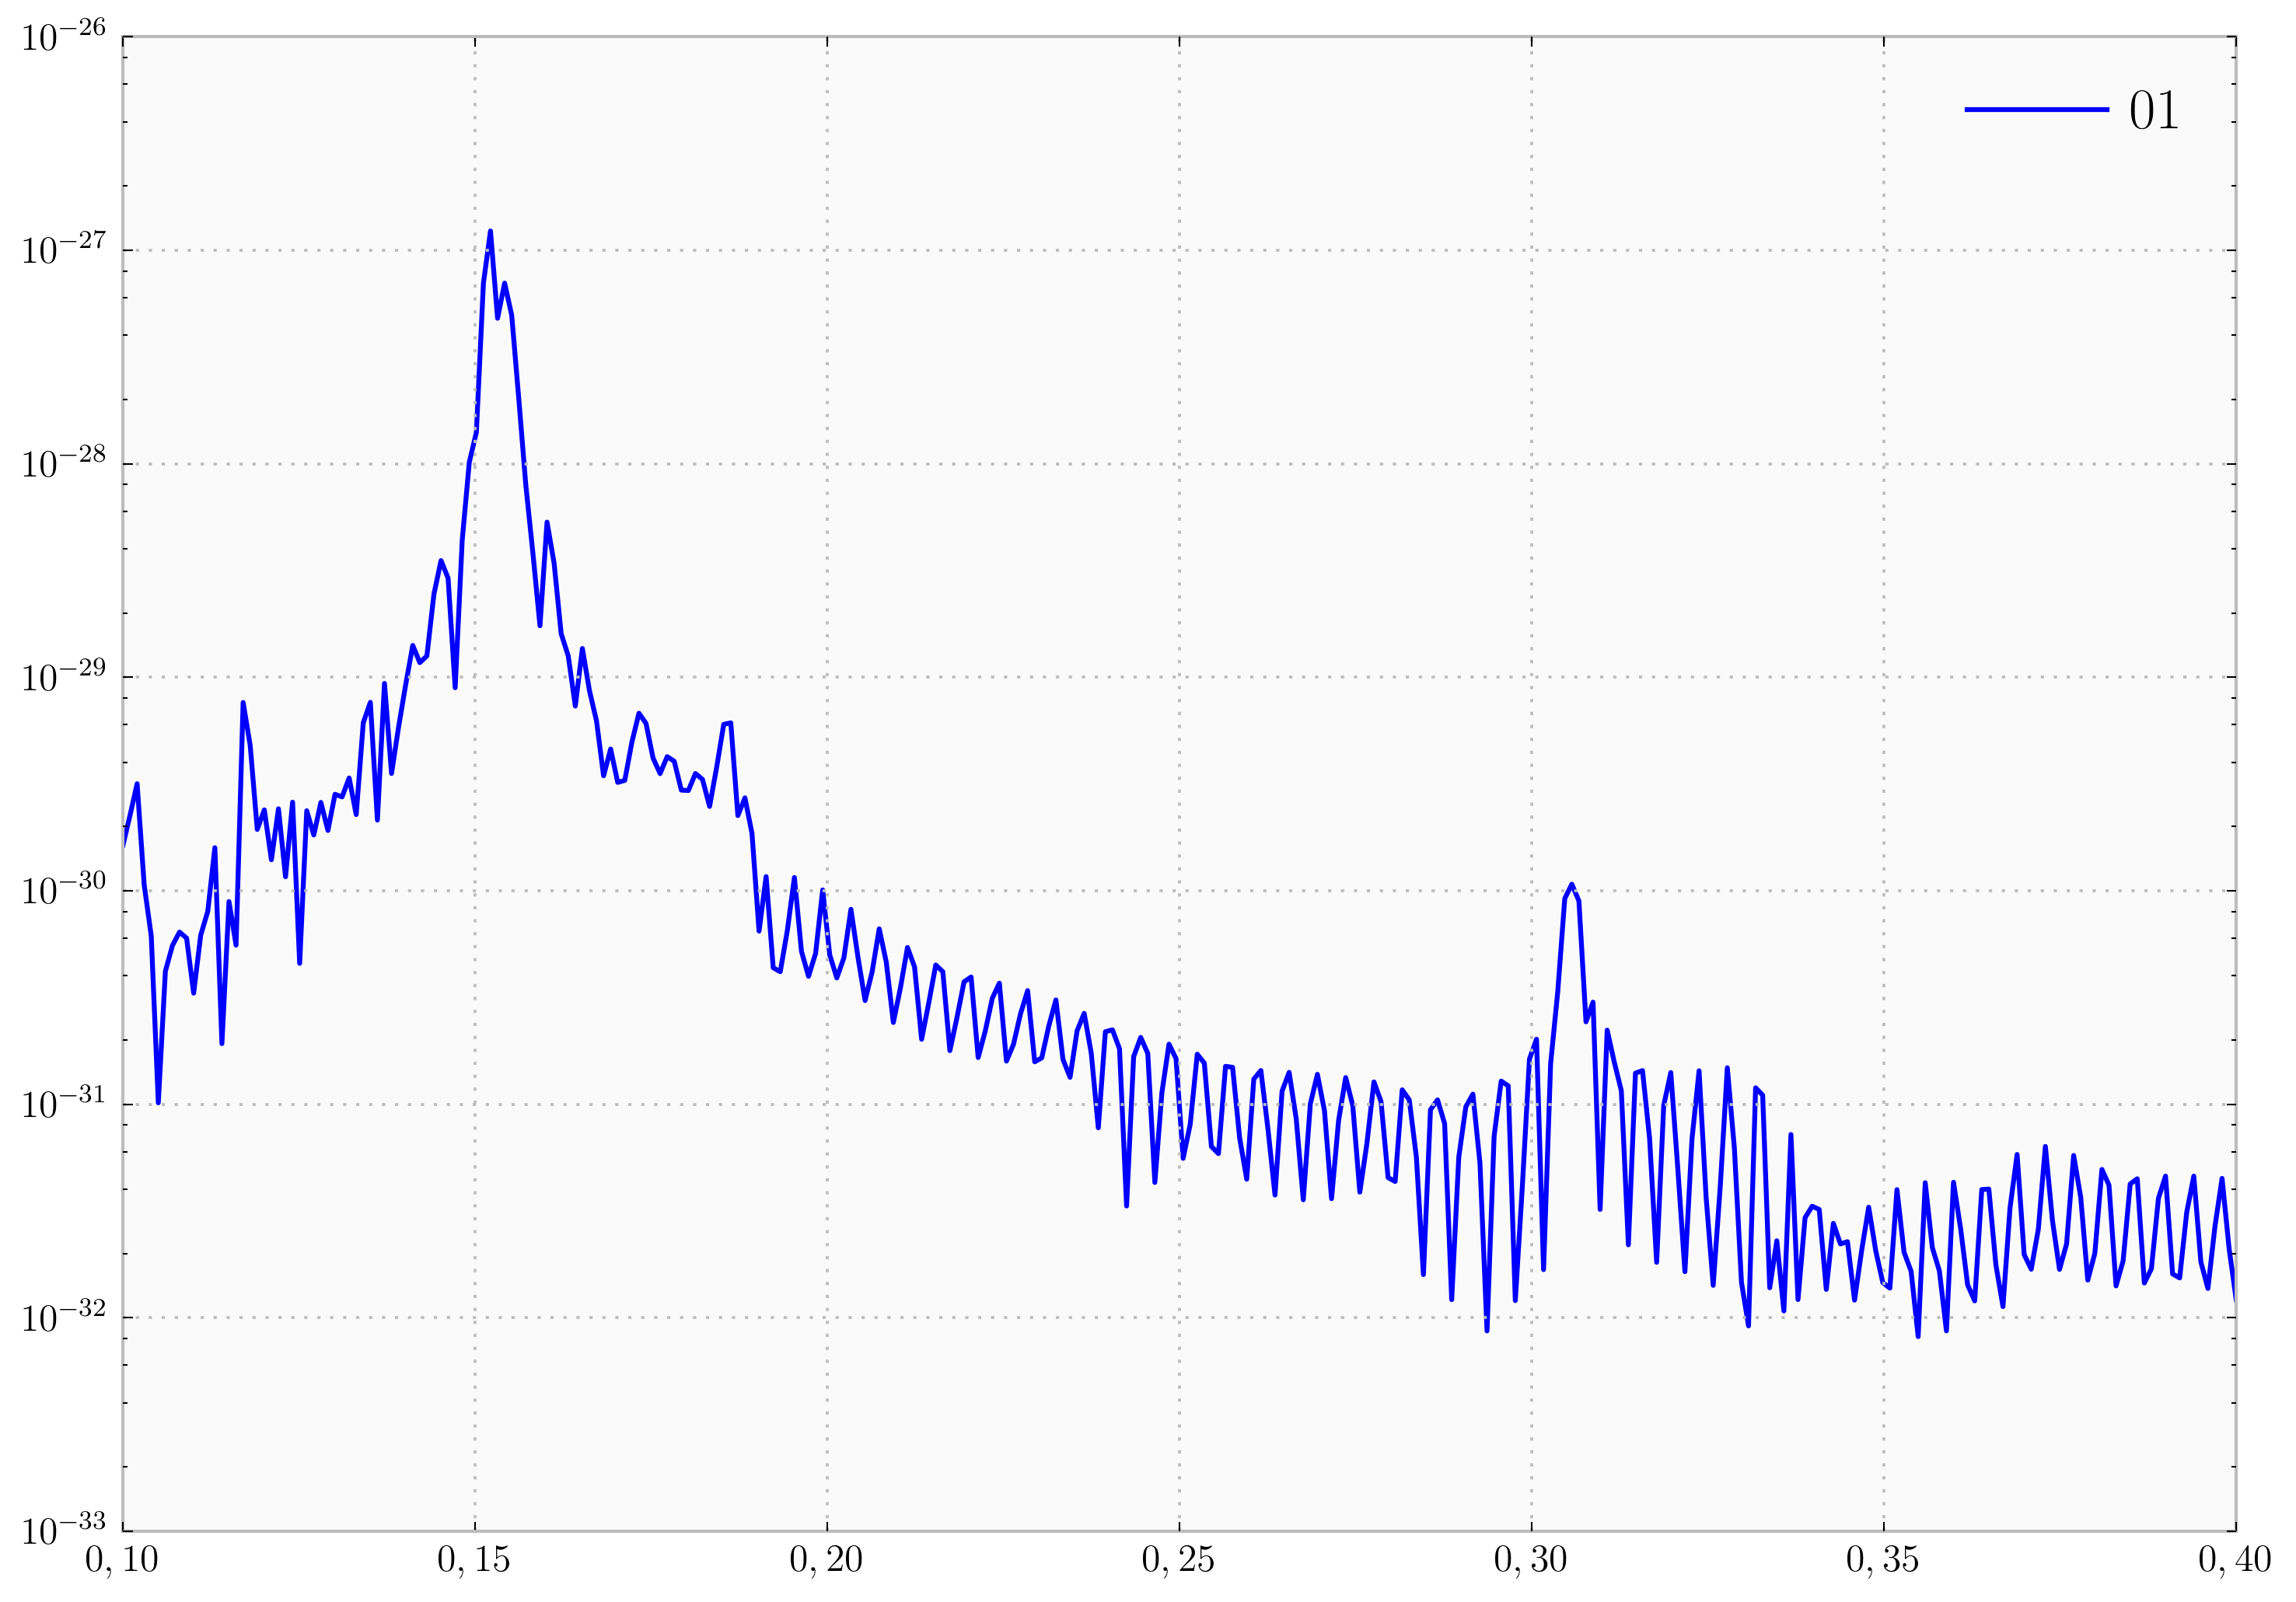

In [7]:
loads1 = np.load("saidas/absorption_1_cos_j.npz")
loads2 = np.load("saidas/absorption_2_cos_j.npz")

energies = loads1['arr_0']
abs1 = loads1['arr_1']
abs2 = loads2['arr_1']


plt.semilogy(energies, energies*np.abs(abs1)+np.abs(abs2), label=r"01")
plt.legend()
plt.show()

In [9]:
df = pd.read_csv('saidas/absorption.csv')

In [10]:
energy = df.energy.values
d1r = df.d1r.values
d2r = df.d2r.values
d1i = df.d1i.values
d2i = df.d2i.values

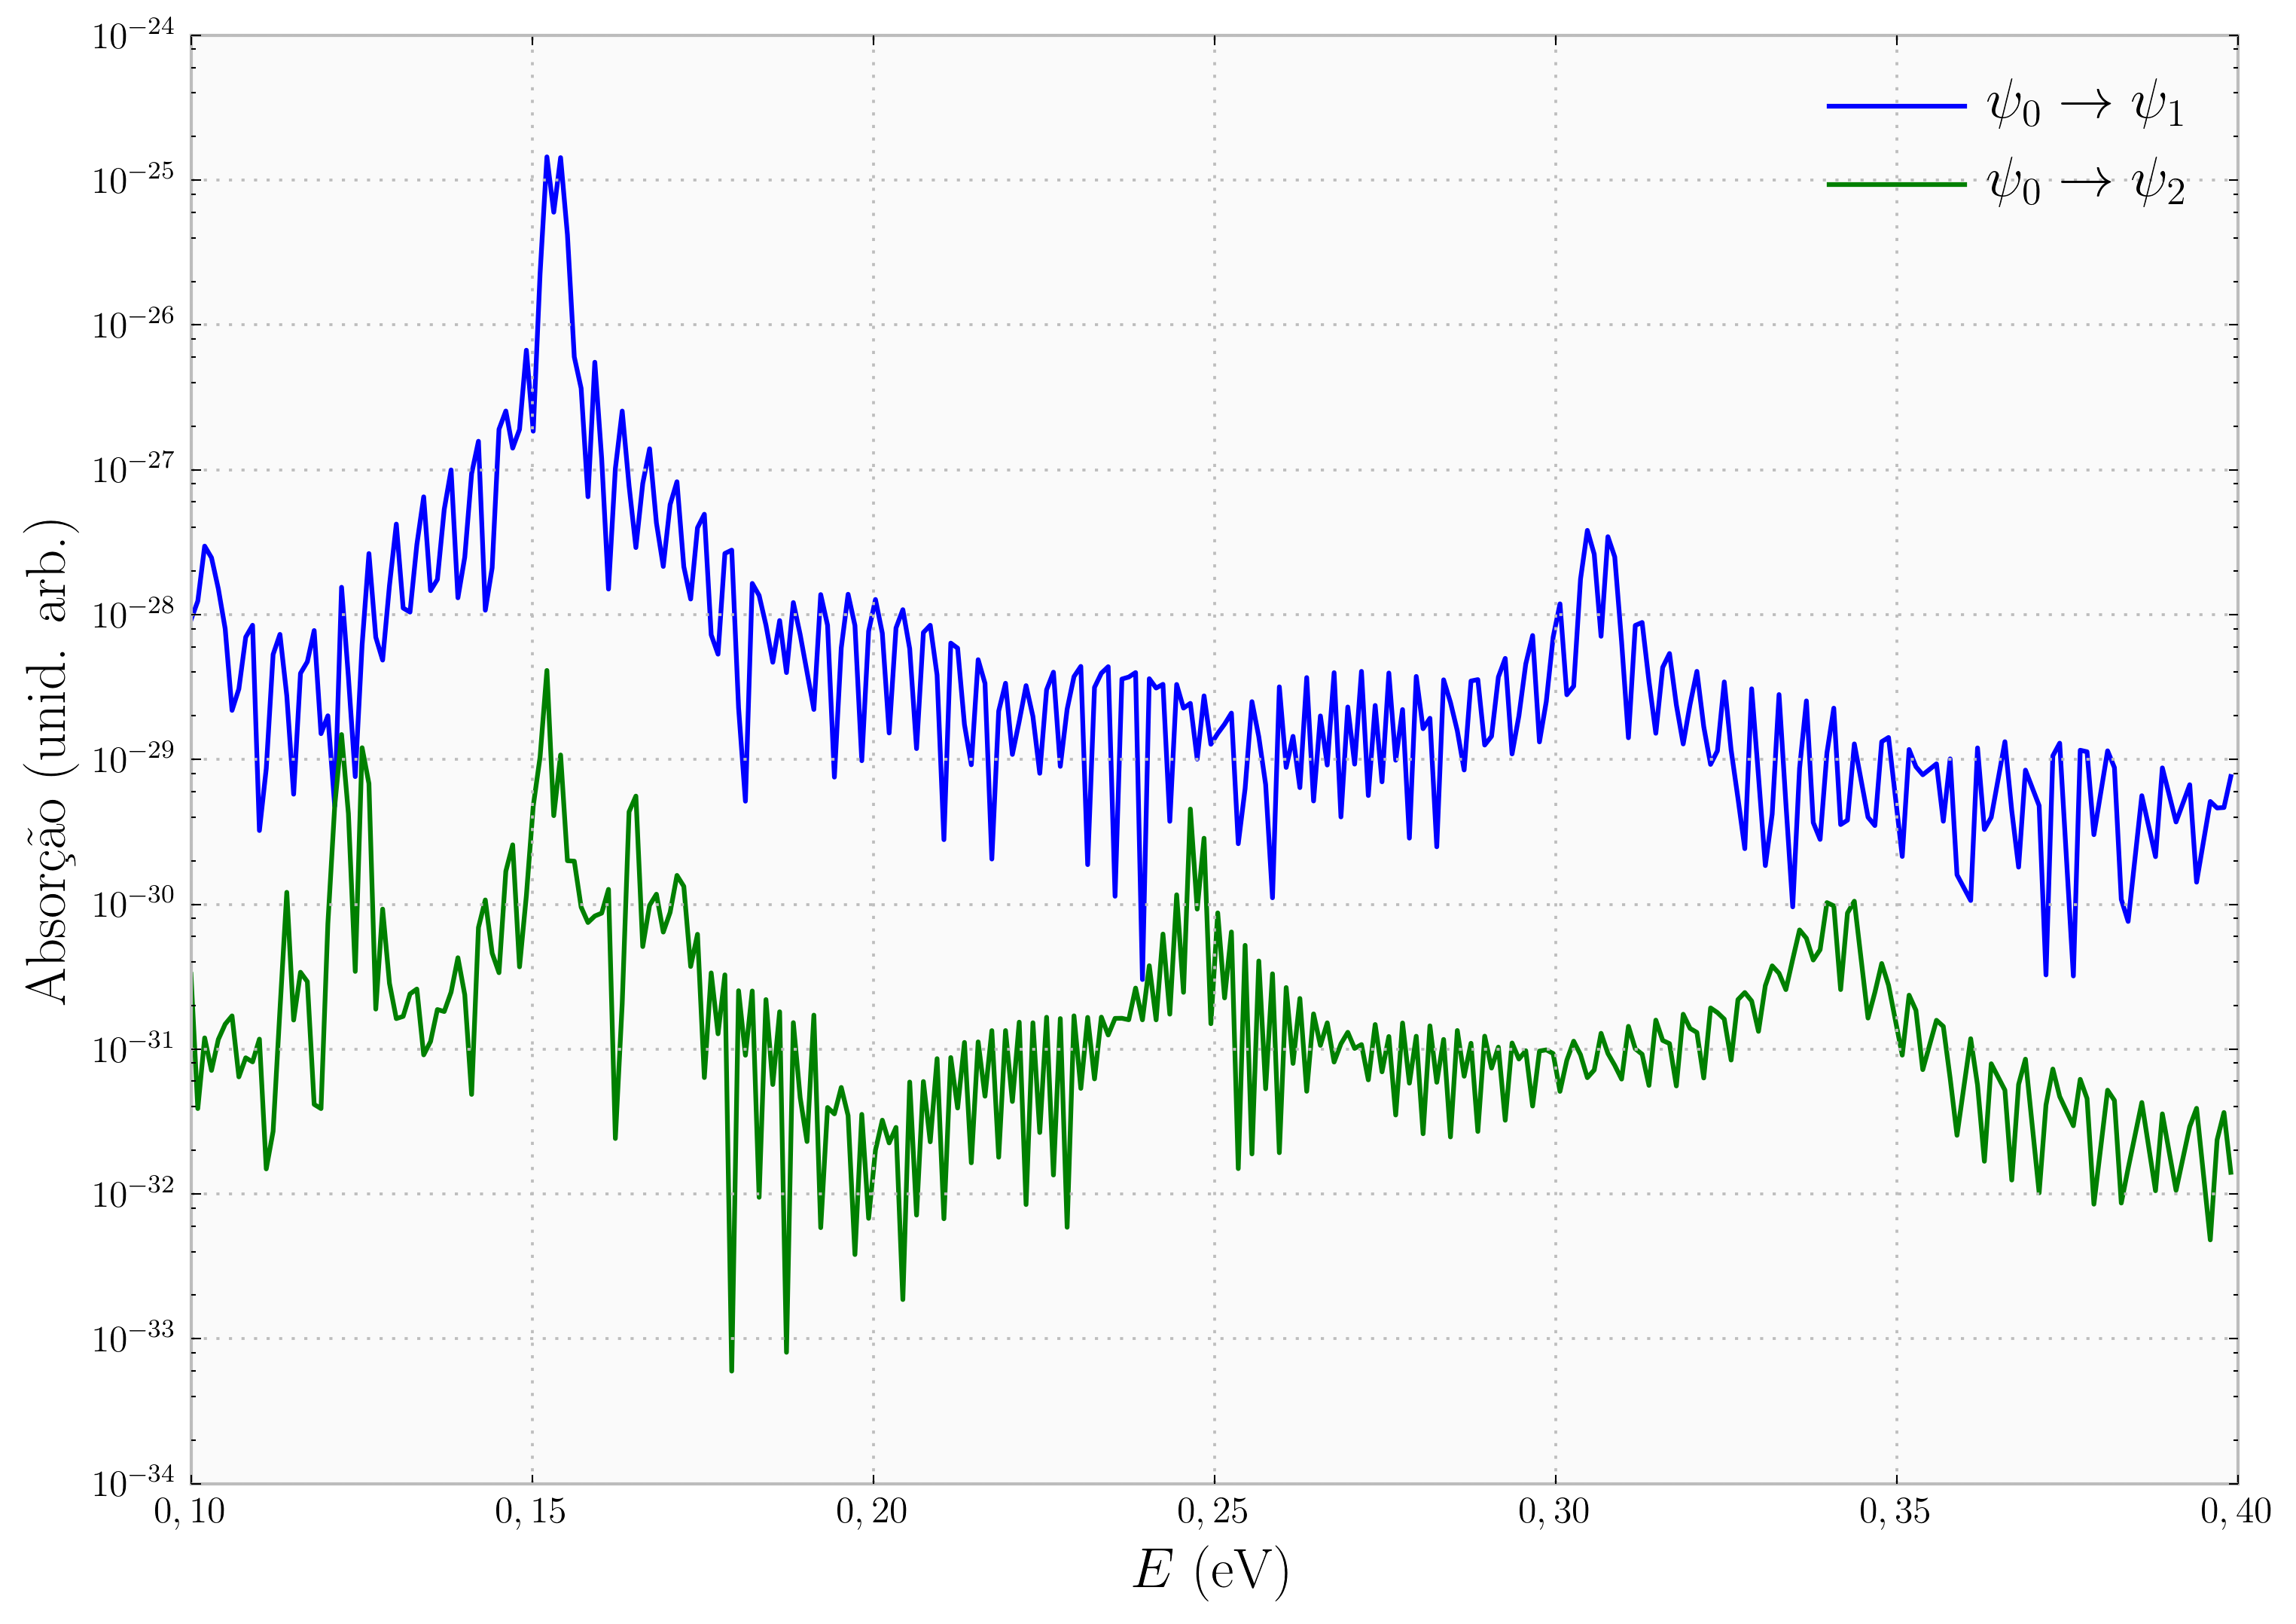

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$E$ (eV)')
ax.set_ylabel(r'Absor\c{c}\~{a}o (unid. arb.)')
ax.semilogy(energy, energy*(np.abs(d1i)), label=r'$\psi_0 \rightarrow \psi_1$')
ax.semilogy(energy, energy*(np.abs(d2i)), label=r'$\psi_0 \rightarrow \psi_2$')
plt.legend()
plt.savefig('figuras/absorcao_degani.png', bbox_inches='tight')

In [14]:
def solve_eigenproblem(H):
    """
    Solve an eigenproblem and return the eigenvalues and eigenvectors.
    """
    vals, vecs = np.linalg.eig(H)
    idx = np.real(vals).argsort()
    vals = vals[idx]
    vecs = vecs.T[idx]

    return vals, vecs

dev = device.copy()
dz = dev['z_au'][1]-dev['z_au'][0]
dz2 = dz**2
V = dev['v_au'].values
m = dev['meff'].values
z = dev['z_au'].values

# Desloca o potencial do Hamiltoniano por shift
sub_diag = np.zeros(N-1, dtype=np.complex_)
main_diag = np.zeros(N, dtype=np.complex_)

# constroi as diagnais da matriz, a principal e as duas semi
# principais
for i in range(N):
    try:
        main_diag[i] = (0.5/dz2)*(1.0/idf(m, i+0.5) + 1.0/idf(m, i-0.5))+(V[i])
    except:
        main_diag[i] = 0.0

    if i < N-1:
        sub_diag[i] = -(0.5/dz2)*(1.0/idf(m, i+0.5))

diagonals = [main_diag, sub_diag, sub_diag]
A = diags(diagonals, [0, -1, 1]).toarray()

res = solve_eigenproblem(A)

print(list(res[0]*au2ev))

# plt.plot(z_au, V)
# for i in range(18):
#     plt.plot(z_au, 0.01*res[1][i]+res[0][i])
# plt.show()

[(-0.11377358717043537+0j), (0.0034508850945540515+0j), (0.0034518887834253612+0j), (0.013787848193557021+0j), (0.013795061929601293+0j), (0.030909366967293555+0j), (0.030987733782352502+0j), (0.039113275569696626+0j), (0.054939640245911324+0j), (0.055086158908226796+0j), (0.085427566025142593+0j), (0.085672861501333478+0j), (0.12097397160987115+0j), (0.12262677668102728+0j), (0.137082877304045+0j), (0.16501563432282984+0j), (0.16791831700885998+0j), (0.20729319090563281+0j), (0.21598632261834461+0j), (0.23416923657334265+0j), (0.26764925477229207+0j), (0.27758275803755211+0j), (0.31738154937792512+0j), (0.33323045666607731+0j), (0.36536623769447579+0j), (0.38983645341610978+0j), (0.42229865956336177+0j), (0.44761568140957592+0j), (0.48544599505669395+0j), (0.51309847289876787+0j), (0.5486587245061737+0j), (0.58589074393163965+0j), (0.61626127712096856+0j), (0.66087073956288367+0j), (0.69349338019591356+0j), (0.73569789469824765+0j), (0.77684842733769988+0j), (0.81565669273990449+0j), 

In [21]:
eigenvalues = res[0][[0,7,14]]*au2ev
eigenstates = []
for i, state in enumerate(res[1]):
    AN = np.sqrt(simps(state.conj() * state, device['z_ang']))
    device['state_%d' % i] = state / AN
    eigenstates.append(state / AN)